# **Deep Learning - Assignment 4**
***experiment with creating two generative architectures***

# **Prepare**

---
Initialize, Load and Pre-Process the two datasets


## Download Datasets

In [ ]:
!gdown --id 1TbSjGYTE74xdAlUDCH-n1-kdF3SsdNFy
# !unzip datasets.zip

Downloading...
From: https://drive.google.com/uc?id=1TbSjGYTE74xdAlUDCH-n1-kdF3SsdNFy
To: /content/datasets.zip
100% 25.6k/25.6k [00:00<00:00, 42.3MB/s]


In [ ]:
!pip install table-evaluator

## Imports

In [ ]:
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import tensorflow as tf
import os, time

from sklearn.preprocessing import PowerTransformer,KBinsDiscretizer, MinMaxScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import plot_model


from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Concatenate, Lambda
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam

from table_evaluator import load_data, TableEvaluator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Constants

In [ ]:
credit_data_path = "german_credit.arff"
diabetes_data_path = "diabetes.arff"

SEED = 42
np.random.seed(SEED)

## Load

### german_credit Dataset

In [ ]:
data = loadarff(credit_data_path)
credit_data = pd.DataFrame(data[0])
credit_data = credit_data.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x) # convert data from bytes to str

In [ ]:
credit_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,A11,6.0,A34,A43,1169.0,A65,A75,4.0,A93,A101,4.0,A121,67.0,A143,A152,2.0,A173,1.0,A192,A201,1
1,A12,48.0,A32,A43,5951.0,A61,A73,2.0,A92,A101,2.0,A121,22.0,A143,A152,1.0,A173,1.0,A191,A201,2
2,A14,12.0,A34,A46,2096.0,A61,A74,2.0,A93,A101,3.0,A121,49.0,A143,A152,1.0,A172,2.0,A191,A201,1
3,A11,42.0,A32,A42,7882.0,A61,A74,2.0,A93,A103,4.0,A122,45.0,A143,A153,1.0,A173,2.0,A191,A201,1
4,A11,24.0,A33,A40,4870.0,A61,A73,3.0,A93,A101,4.0,A124,53.0,A143,A153,2.0,A173,2.0,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12.0,A32,A42,1736.0,A61,A74,3.0,A92,A101,4.0,A121,31.0,A143,A152,1.0,A172,1.0,A191,A201,1
996,A11,30.0,A32,A41,3857.0,A61,A73,4.0,A91,A101,4.0,A122,40.0,A143,A152,1.0,A174,1.0,A192,A201,1
997,A14,12.0,A32,A43,804.0,A61,A75,4.0,A93,A101,4.0,A123,38.0,A143,A152,1.0,A173,1.0,A191,A201,1
998,A11,45.0,A32,A43,1845.0,A61,A73,4.0,A93,A101,4.0,A124,23.0,A143,A153,1.0,A173,1.0,A192,A201,2


### diabetes Dataset

In [ ]:
data = loadarff(diabetes_data_path)
diabetes_data = pd.DataFrame(data[0])
diabetes_data = diabetes_data.applymap(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x) # convert data from bytes to str

In [ ]:
diabetes_data

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,tested_positive
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,tested_negative
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,tested_positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,tested_negative
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,tested_negative
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,tested_negative
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,tested_positive


## Pre-Process

In [ ]:
def preprocess_tabular_df(df,dist_features_cols,target_col):
  """
  Pre-Process Pipeline for tabular dataset

  1. Drop Label column - no need to generate samples with label
  2. Convert Str Categories to thier value index
  3. Normalize all values to the range [0,1]

  :param df: dataframe, the data set to preprocess
  :param dist_features_cols: all the columns name of categorial features in df
  :param target_col: the column name of the label in df
  :return: 
      result: the processed dataset
      pipeline: tuple, use as param for inverting df back to tabular data
  """
  # drop label
  res = df.copy()
  res.drop(target_col, inplace=True, axis=1)
  
  # covert category values to index
  categorial_transformer = {}
  for col in dist_features_cols:
    categorial_transformer[col] = res[col].astype('category').cat.categories
    res[col] = res[col].astype('category').cat.codes
  
  # normalize
  pt = MinMaxScaler()
  # pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
  res = pd.DataFrame(pt.fit_transform(res),columns=res.columns)

  # prepare to discretize for inverting back to categories values
  discretize_transformer = {}
  for col in dist_features_cols:
    discretize_transformer[col] = list(res[col].unique())
  
  return res, (categorial_transformer,pt,discretize_transformer)

In [ ]:
def inverse_preprocess_to_tabular(results,pre_process_pipeline):
  """
  Inverse Pre-Process transformation, convert a given results of generated samples
  back to the original feature space before preprocessing by applying the inverted
  transformations in the oposite order
  
  1. Discretize to the Categories Values (of thier idx) in order to convert them to str
  2. Inverse Normalizing to the original value range
  3. Convert Categories indexs to thier str values
  
  :param results: dataframe, a given samples to convert that generated from a GAN model
  :param pre_process_pipeline: tuple, pipeline generated from preprocess_tabular_df method
  :return: 
      result: dataframe, the samples after convertions
  """
  # init 
  categorial_transformer,pt,discretize_transformer = pre_process_pipeline
  if len(results) == 0:
    return results
  res = results.copy()
  
  # Discretize categorial variables
  for col in categorial_transformer:
    res[col] = res[col].apply(lambda value: min(discretize_transformer[col], key=lambda list_value : abs(list_value - value)))

  # inverse normalize
  res = pd.DataFrame(pt.inverse_transform(res),columns=res.columns)

  # covert to categorial values from codes
  for col in categorial_transformer:
    res[col] = res[col].apply(lambda v: round(v))
    res[col] = pd.Categorical.from_codes(list(res[col]),categorial_transformer[col])

  return res

### german_credit Dataset

In [ ]:
credit_categorial_features = ['1','3','4','6','7','9','10','12','14','15','17','19','20']
credit_label = '21'

In [ ]:
credit_data[credit_label] = credit_data[credit_label].apply(lambda c: 1 if c == '2' else 0)

credit_df, credit_pipeline = preprocess_tabular_df(credit_data,credit_categorial_features,credit_label)

credit_df_bbox = credit_df.copy()
credit_df_bbox[credit_label] = credit_data[credit_label]

In [ ]:
credit_df # for part 1

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.000000,0.029412,1.00,0.444444,0.050567,1.00,1.00,1.000000,0.666667,0.0,1.000000,0.000000,0.857143,1.0,0.5,0.333333,0.666667,0.0,1.0,0.0
1,0.333333,0.647059,0.50,0.444444,0.313690,0.00,0.50,0.333333,0.333333,0.0,0.333333,0.000000,0.053571,1.0,0.5,0.000000,0.666667,0.0,0.0,0.0
2,1.000000,0.117647,1.00,0.777778,0.101574,0.00,0.75,0.333333,0.666667,0.0,0.666667,0.000000,0.535714,1.0,0.5,0.000000,0.333333,1.0,0.0,0.0
3,0.000000,0.558824,0.50,0.333333,0.419941,0.00,0.75,0.333333,0.666667,1.0,1.000000,0.333333,0.464286,1.0,1.0,0.000000,0.666667,1.0,0.0,0.0
4,0.000000,0.294118,0.75,0.000000,0.254209,0.00,0.50,0.666667,0.666667,0.0,1.000000,1.000000,0.607143,1.0,1.0,0.333333,0.666667,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.000000,0.117647,0.50,0.333333,0.081765,0.00,0.75,0.666667,0.333333,0.0,1.000000,0.000000,0.214286,1.0,0.5,0.000000,0.333333,0.0,0.0,0.0
996,0.000000,0.382353,0.50,0.111111,0.198470,0.00,0.50,1.000000,0.000000,0.0,1.000000,0.333333,0.375000,1.0,0.5,0.000000,1.000000,0.0,1.0,0.0
997,1.000000,0.117647,0.50,0.444444,0.030483,0.00,1.00,1.000000,0.666667,0.0,1.000000,0.666667,0.339286,1.0,0.5,0.000000,0.666667,0.0,0.0,0.0
998,0.000000,0.602941,0.50,0.444444,0.087763,0.00,0.50,1.000000,0.666667,0.0,1.000000,1.000000,0.071429,1.0,1.0,0.000000,0.666667,0.0,1.0,0.0


In [ ]:
credit_df_bbox # for part 2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.000000,0.029412,1.00,0.444444,0.050567,1.00,1.00,1.000000,0.666667,0.0,1.000000,0.000000,0.857143,1.0,0.5,0.333333,0.666667,0.0,1.0,0.0,0
1,0.333333,0.647059,0.50,0.444444,0.313690,0.00,0.50,0.333333,0.333333,0.0,0.333333,0.000000,0.053571,1.0,0.5,0.000000,0.666667,0.0,0.0,0.0,1
2,1.000000,0.117647,1.00,0.777778,0.101574,0.00,0.75,0.333333,0.666667,0.0,0.666667,0.000000,0.535714,1.0,0.5,0.000000,0.333333,1.0,0.0,0.0,0
3,0.000000,0.558824,0.50,0.333333,0.419941,0.00,0.75,0.333333,0.666667,1.0,1.000000,0.333333,0.464286,1.0,1.0,0.000000,0.666667,1.0,0.0,0.0,0
4,0.000000,0.294118,0.75,0.000000,0.254209,0.00,0.50,0.666667,0.666667,0.0,1.000000,1.000000,0.607143,1.0,1.0,0.333333,0.666667,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.000000,0.117647,0.50,0.333333,0.081765,0.00,0.75,0.666667,0.333333,0.0,1.000000,0.000000,0.214286,1.0,0.5,0.000000,0.333333,0.0,0.0,0.0,0
996,0.000000,0.382353,0.50,0.111111,0.198470,0.00,0.50,1.000000,0.000000,0.0,1.000000,0.333333,0.375000,1.0,0.5,0.000000,1.000000,0.0,1.0,0.0,0
997,1.000000,0.117647,0.50,0.444444,0.030483,0.00,1.00,1.000000,0.666667,0.0,1.000000,0.666667,0.339286,1.0,0.5,0.000000,0.666667,0.0,0.0,0.0,0
998,0.000000,0.602941,0.50,0.444444,0.087763,0.00,0.50,1.000000,0.666667,0.0,1.000000,1.000000,0.071429,1.0,1.0,0.000000,0.666667,0.0,1.0,0.0,1


### diabetes Dataset

In [ ]:
diabetes_categorial_features = []
diabetes_label = 'class'

In [ ]:
diabetes_data[diabetes_label] = diabetes_data[diabetes_label].apply(lambda c: 1 if 'positive' in c else 0)

diabetes_df, diabetes_pipeline = preprocess_tabular_df(diabetes_data,diabetes_categorial_features,diabetes_label)

diabetes_df_bbox = diabetes_df.copy()
diabetes_df_bbox[diabetes_label] = diabetes_data[diabetes_label]

In [ ]:
diabetes_df # for part 1

,preg,plas,pres,skin,insu,mass,pedi,age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000
...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333


In [ ]:
diabetes_df_bbox # for part 2

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000,0
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000,0
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000,0
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333,1


# Part 1 - Simple Generative Adversarial Networks (GAN)

---

implementation of a simple GAN model for tabular data

In [ ]:
simple_gan_parameters = {
    "batch_size" : 128,
    "verbose": 1,
    "gen_dim": 128,
    "disc_dim": 50,
    "loss": 'binary_crossentropy',
    "noise_dim": 64,
    "epochs" : 250,
    "optimizer": Adam(5e-4 , 0.5),
    "metrics": ['accuracy'],
    "early_stop_wait": 10
}

## Model

### Generator

In [ ]:
def get_generator(dim, gen_data_dim):
  """
  Get the Generator Model

  :param dim: generator inner Dense size
  :param gen_data_dim: number of feature of the data
  :return: 
    generator: keras model
  """
  
  generator = Sequential(name = 'Generator')
  
  generator.add(Dense(dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(dim * 2))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(dim * 3))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Dense(dim * 4))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Dense(dim * 5))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Dense(gen_data_dim))

  return generator

### Discriminator

In [ ]:
def get_discriminator(dim):
  """
  Get the Discriminator Model

  :param dim: discriminator inner Dense size
  :return: 
    discriminator: keras model
  """

  discriminator = Sequential(name = 'Discriminator')
  
  discriminator.add(Dense(dim * 3, activation='relu'))
  discriminator.add(Dropout(0.1))
  discriminator.add(Dense(dim * 2, activation='relu'))
  discriminator.add(Dropout(0.1))
  discriminator.add(Dense(dim, activation='relu'))
  discriminator.add(Dense(1, activation='sigmoid'))

  return discriminator

### Simple GAN

In [ ]:
class SimpleGAN():
  """
  Simple GAN Model for tabular data
  """
  def __init__(self,data_dim,gen_builder=get_generator,disc_builder=get_discriminator,parameters=simple_gan_parameters):
    """
    Constructor

    :param data_dim: int, number of features of the generated data
    :param gen_builder: generator build function
    :param disc_builder: discriminator build function
    :param parameters: dict, model hyper parameters
    """
    self.parameters = parameters
    model, generator, discriminator = SimpleGAN.build_model(data_dim,gen_builder,disc_builder,parameters)

    self.model = model
    self.generator = generator
    self.discriminator = discriminator

  def build_model(data_dim,gen_builder,disc_builder,parameters):
    """
    Static Class Method, Build a simple GAN model base on a given parameters

    :param data_dim: int, number of features of the generated data
    :param gen_builder: generator build function
    :param disc_builder: discriminator build function
    :param parameters: dict, model hyper parameters
    :return: 
        model: keras model, the GAN model
        generator: keras model, the generator model
        discriminator: keras model, the discriminator model
    """

    generator = gen_builder(parameters["gen_dim"],data_dim)

    discriminator = disc_builder(parameters["disc_dim"])
    discriminator.compile(loss=parameters["loss"],optimizer=parameters["optimizer"],metrics=parameters["metrics"])

    # For the GAN model we will only train the generator - (we already compiled the discriminator to use as the first step)
    discriminator.trainable = False

    noise_input = Input(parameters["noise_dim"])
    sample = generator(noise_input)
    validity = discriminator(sample)
    
    model = Model(noise_input, validity,name='Simple_GAN')
    model.compile(loss=parameters["loss"], optimizer=parameters["optimizer"])

    return model, generator, discriminator

  def train(self,df):
    """
    Fit the GAN model to a given dataset

    :param df: dataframe, dataset samples to fit the model
    :return:
      history: tuple, with training history information
    """

    batch_size = self.parameters["batch_size"]
    n_batch_per_epoch = int(np.floor(len(df) / batch_size))
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    idx_list = np.arange(len(df))

    start_t = time.time()
    
    discriminator_loss = []
    generator_loss = []
    discriminator_acc = []

    best_disc_loss = float('inf')
    disc_loss_no_change = 0
    best_gen_loss = float('inf')
    gen_loss_no_change = 0

    for epoch in range(self.parameters["epochs"]):
      
      np.random.shuffle(idx_list)
      
      generator_loss_list = np.empty(n_batch_per_epoch)
      discriminator_loss_list = np.empty(n_batch_per_epoch)
      discriminator_acc_list = np.empty(n_batch_per_epoch)

      start_e = time.time()

      for batch_id in range(n_batch_per_epoch):
        
        indexes = idx_list[batch_id * batch_size : (batch_id+1) * batch_size]
        batch = df.loc[indexes]
        
        # First Step = discriminator training
        generator_data = self.generate_samples(batch_size)
        
        discriminator_loss_real = self.discriminator.train_on_batch(batch, valid)
        discriminator_loss_fake = self.discriminator.train_on_batch(generator_data, fake)
        d_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        
        discriminator_loss_list[batch_id] = d_loss[0]
        discriminator_acc_list[batch_id] = 100 * d_loss[1]

        # Second Step = generator training
        noise = np.random.normal(0, 1, (batch_size, self.parameters["noise_dim"]))
        generator_loss_list[batch_id] = self.model.train_on_batch(noise, valid)

      disc_epoch_loss = discriminator_loss_list.mean()
      gen_epoch_loss = generator_loss_list.mean()
      disc_epoch_acc = discriminator_acc_list.mean()

      discriminator_loss.append(disc_epoch_loss)
      generator_loss.append(gen_epoch_loss)
      discriminator_acc.append(disc_epoch_acc)
      if epoch % self.parameters["verbose"] == 0:
        print("Epoch {0:} : Elapsed[{1:1.3f} sec] Discriminator[loss: {2:1.3f}, acc: {3:1.3f}] Generator[loss: {4:1.3f}]".format(epoch,round(time.time()-start_e,3) ,round(discriminator_loss_list.mean(),3), round(discriminator_acc_list.mean(),3), round(generator_loss_list.mean(),3)))

      # early stop if both generator, discriminator not improved for "early_stop_wait" epochs
      if disc_epoch_loss < best_disc_loss:
        best_disc_loss = disc_epoch_loss
        disc_loss_no_change = 0
      else:
        disc_loss_no_change += 1

      if gen_epoch_loss < best_gen_loss:
        best_gen_loss = gen_epoch_loss
        gen_loss_no_change = 0
      else:
        gen_loss_no_change += 1

      if disc_loss_no_change > self.parameters["early_stop_wait"] and gen_loss_no_change > self.parameters["early_stop_wait"]:
        break
      
    print("Fit Time = {} sec".format(round(time.time() - start_t,3)))
    return discriminator_acc, discriminator_loss, generator_loss

  def is_real_sample(self,samples):
    """
    discriminator predicts if samples are real (1) or fake (0)

    :param samples: samples to check
    :return: 
      pred: array size of samples with predictions on each sample. 1 for 'real' 0 for 'fake'
    """
    pred = self.discriminator.predict(samples)
    
    pred[pred <= 0.5] = 0
    pred[pred > 0.5] = 1
    
    return pred

  def generate_samples(self,n=100):
    """
    Generate GAN samples

    :param n: number of samples to generate
    :return: 
      samples: ndarray shape of (n,data_dim)
    """
    noise = np.random.normal(0, 1, (n, self.parameters["noise_dim"]))
    generator_data = self.generator.predict(noise)
    return generator_data

  def plot(self):
    """
    Plot the GAN model
    """
    imageName = "model.png"
    plot_model(self.model,to_file=imageName,show_shapes=True)
    display(Image(filename=imageName))

  def summary(self):
    """
    Print Summary of the GAN model and its Components
    """
    self.model.summary()
    print()
    print("=" * 100)
    print()
    self.generator.summary()
    print()
    print("-" * 100)
    print()
    self.discriminator.summary()
    print()
    print("=" * 100)


## Evaluation

In [ ]:
def eval_simple_GAN(model,df,pipeline):
  """
  Evaluate a given GAN model

  :param model: simple GAN model
  :param df: training dataset
  :param pipeline: pre-process pipeline that was generated from 'preprocess_tabular_df'
  :return: 
    df_not_detected: dataframe, generated samples that passed as real samples
    df_detected: dataframe, generated samples that was detected as fake samples
  """

  # basic visualization
  fake_samples = model.generate_samples(len(df))
  results = model.is_real_sample(fake_samples)
  fake_samples = pd.DataFrame(fake_samples,columns=df.columns)
  table_evaluator = TableEvaluator(df, fake_samples)
  
  print()
  table_evaluator.visual_evaluation()
  print()

  print("=" * 100)
  # generate 100 samples - How many were able to pass as real samples?
  fake_samples = model.generate_samples()
  results = model.is_real_sample(fake_samples)
  
  print()
  
  print("Discriminator Could not detect {}/{} of fake samples (they passed as real samples)".format(results.sum(),len(results)))
  
  # show samples that fooled the detector and some that not
  detected_as_fake_mask = np.asarray(results == 0)
  fake_samples = pd.DataFrame(fake_samples,columns=df.columns)

  df_not_detected = inverse_preprocess_to_tabular(pd.DataFrame(fake_samples[~detected_as_fake_mask],columns=df.columns),pipeline)
  df_detected = inverse_preprocess_to_tabular(pd.DataFrame(fake_samples[detected_as_fake_mask],columns=df.columns),pipeline)
  
  return df_not_detected, df_detected

In [ ]:
def show_train_history(history):
  """
  Plot model fit history

  :param history: tuple, with training history information that was generatet from 'train'
  """
  # Evaluate the model
  discriminator_acc_list, discriminator_loss_list, generator_loss_list = history

  plt.plot(discriminator_acc_list, label='discriminator_accuracy')
  plt.xlabel('Epoch')
  plt.title("Training Accuracy")
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(discriminator_loss_list, label="discriminator_loss")
  plt.plot(generator_loss_list, label="generator_loss")
  plt.xlabel('Epoch')
  plt.title("Training Loss")
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## german_credit Dataset

### Training

In [ ]:
credit_GAN = SimpleGAN(len(credit_df.columns))

In [ ]:
credit_GAN.summary()

Model: "Simple_GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
Generator (Sequential)       (None, 20)                679828    
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 23351     
Total params: 703,179
Trainable params: 679,060
Non-trainable params: 24,119
_________________________________________________________________


Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 128)               0         
________________________

In [ ]:
history = credit_GAN.train(credit_df)

Epoch 0 : Elapsed[2.599 sec] Discriminator[loss: 0.879, acc: 49.888] Generator[loss: 0.336]
Epoch 1 : Elapsed[0.891 sec] Discriminator[loss: 0.720, acc: 48.214] Generator[loss: 1.400]
Epoch 2 : Elapsed[0.885 sec] Discriminator[loss: 0.728, acc: 41.183] Generator[loss: 0.941]
Epoch 3 : Elapsed[0.917 sec] Discriminator[loss: 0.711, acc: 49.051] Generator[loss: 0.833]
Epoch 4 : Elapsed[0.917 sec] Discriminator[loss: 0.732, acc: 30.078] Generator[loss: 0.711]
Epoch 5 : Elapsed[0.898 sec] Discriminator[loss: 0.714, acc: 29.576] Generator[loss: 0.697]
Epoch 6 : Elapsed[0.934 sec] Discriminator[loss: 0.717, acc: 22.656] Generator[loss: 0.684]
Epoch 7 : Elapsed[0.885 sec] Discriminator[loss: 0.706, acc: 39.844] Generator[loss: 0.715]
Epoch 8 : Elapsed[0.954 sec] Discriminator[loss: 0.705, acc: 34.487] Generator[loss: 0.693]
Epoch 9 : Elapsed[0.945 sec] Discriminator[loss: 0.701, acc: 37.835] Generator[loss: 0.673]
Epoch 10 : Elapsed[0.927 sec] Discriminator[loss: 0.706, acc: 38.393] Generator[

### Evaluation

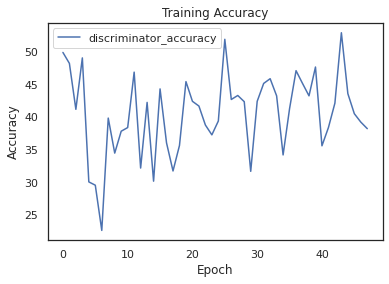

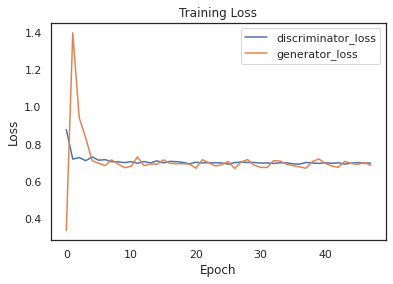

In [ ]:
show_train_history(history)

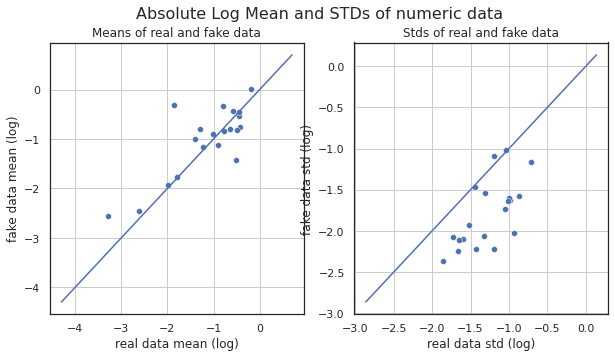

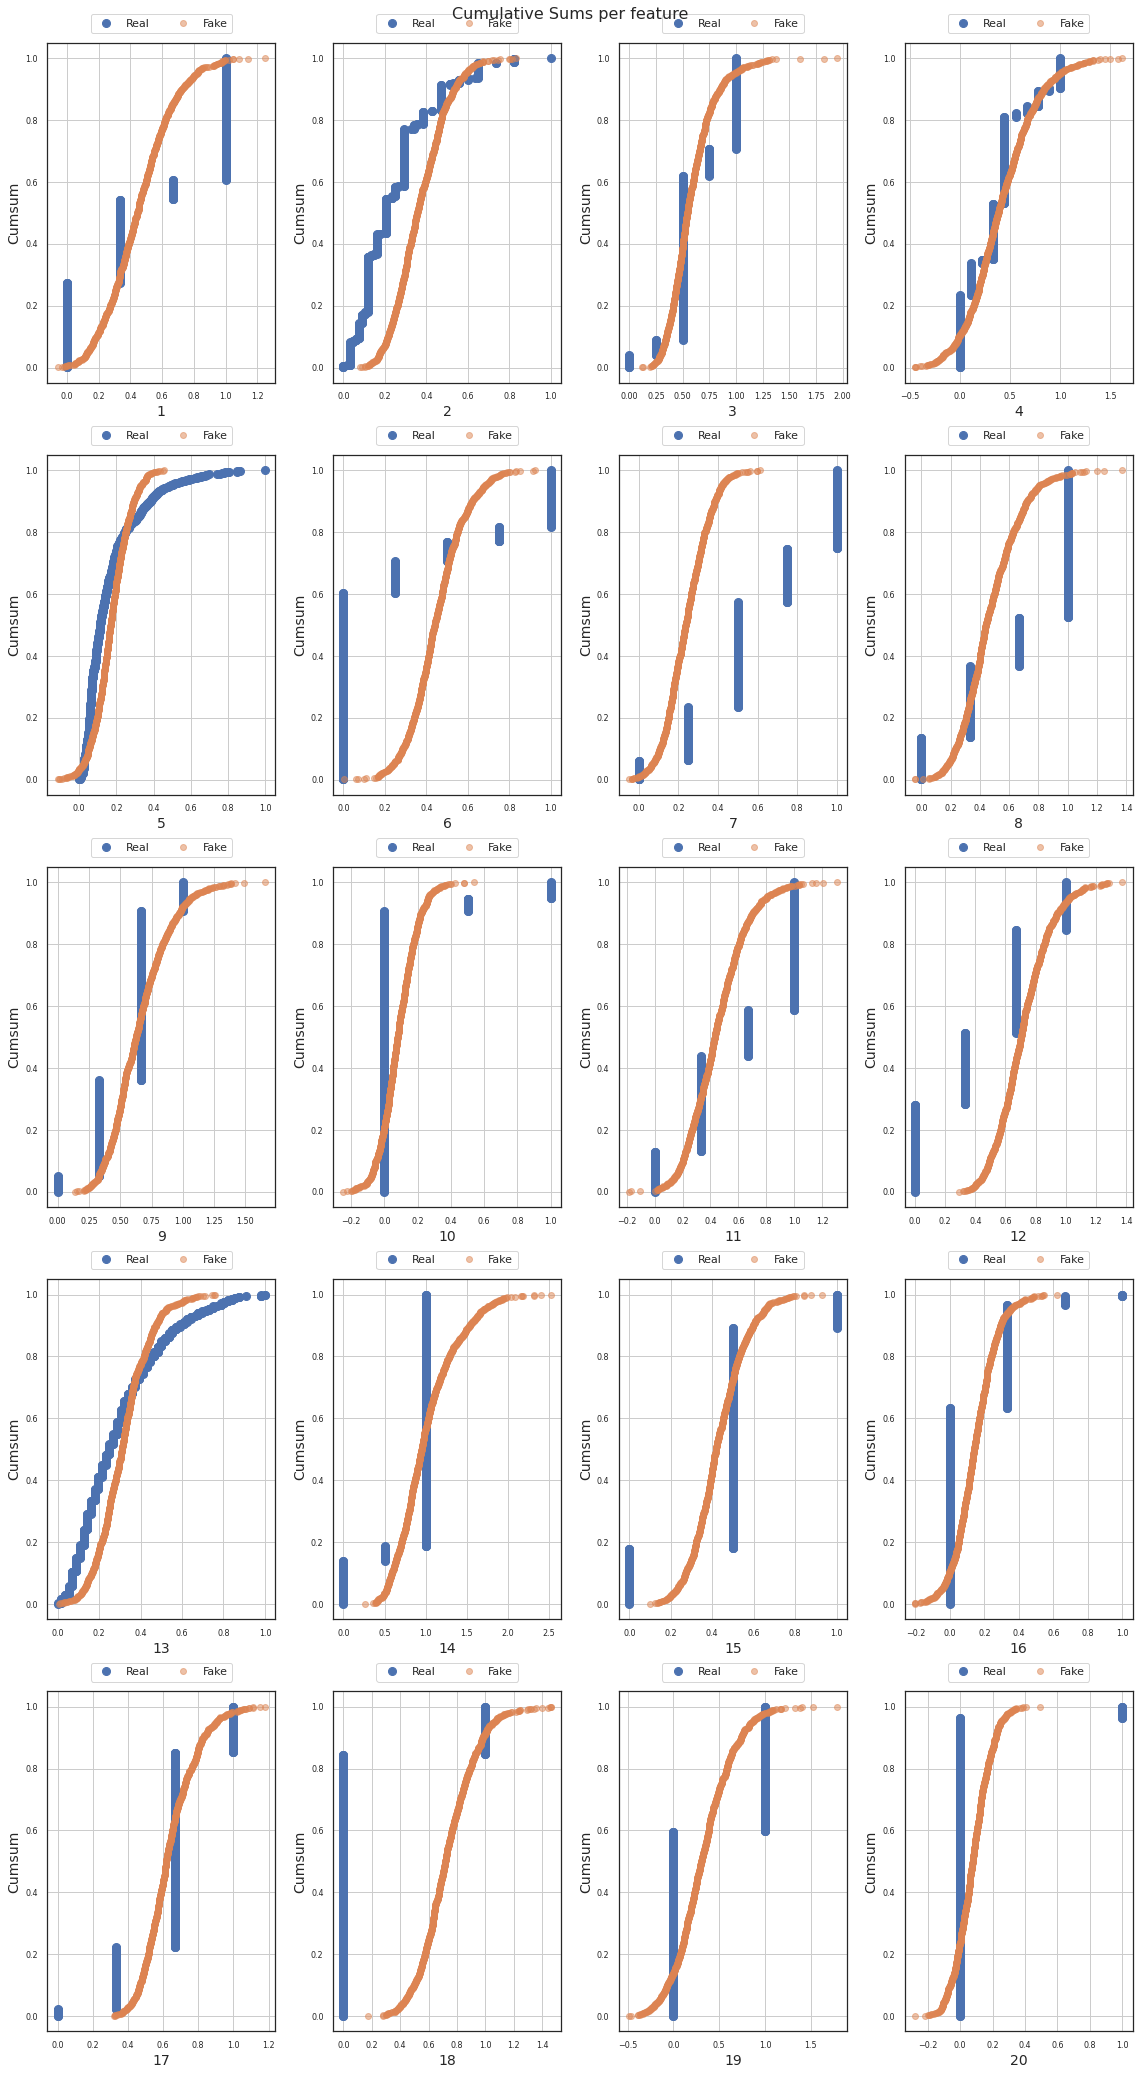

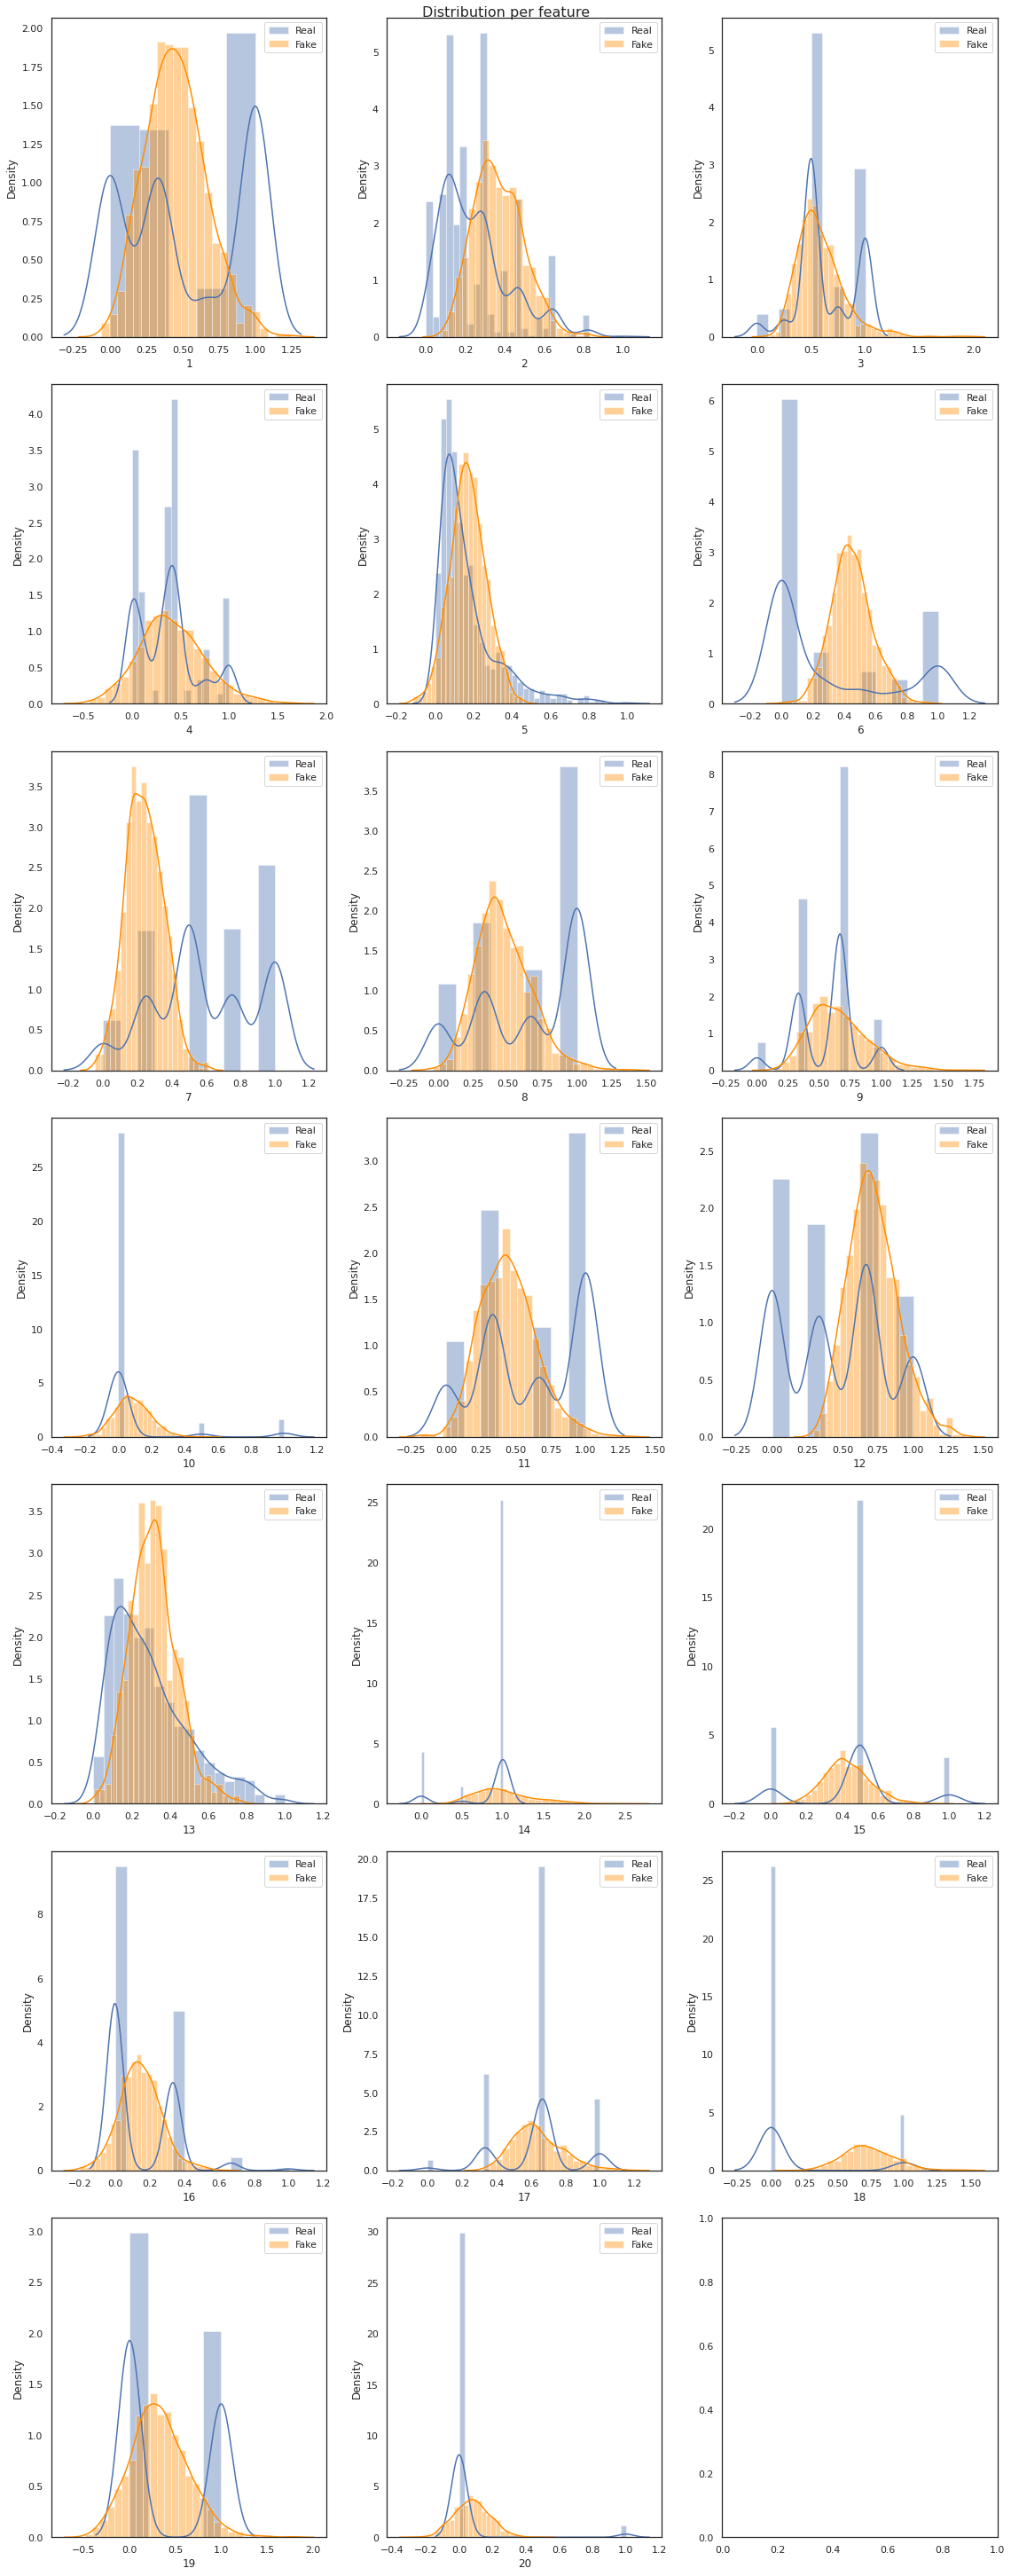

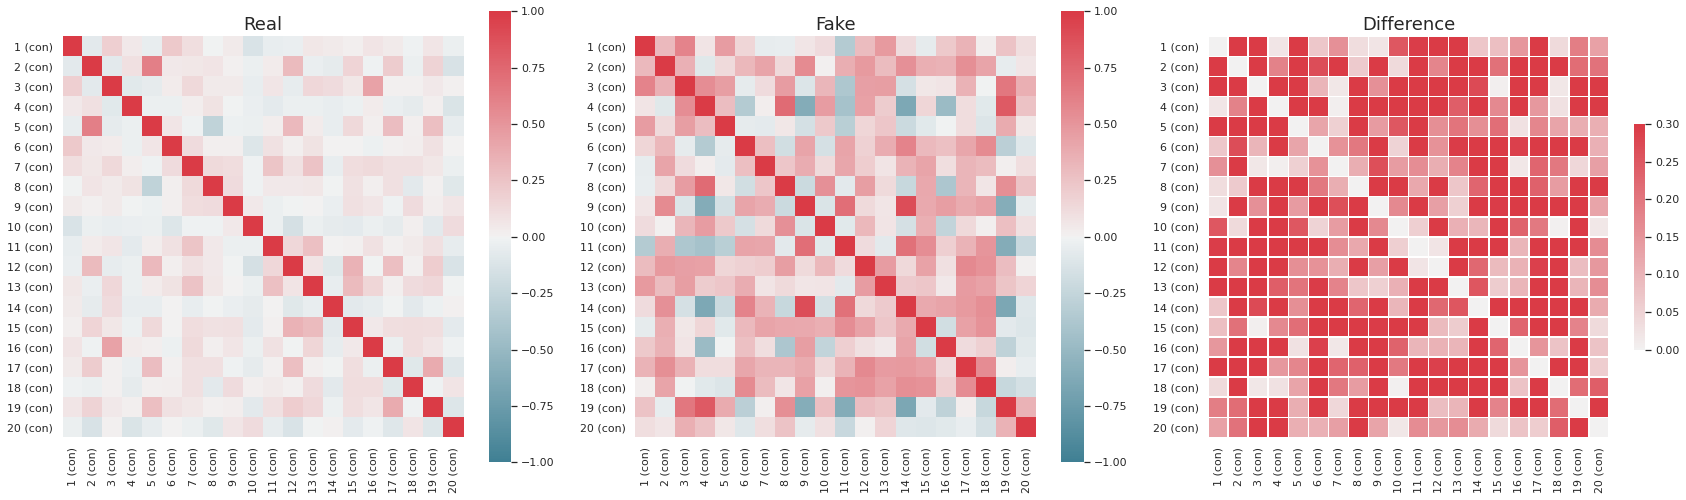

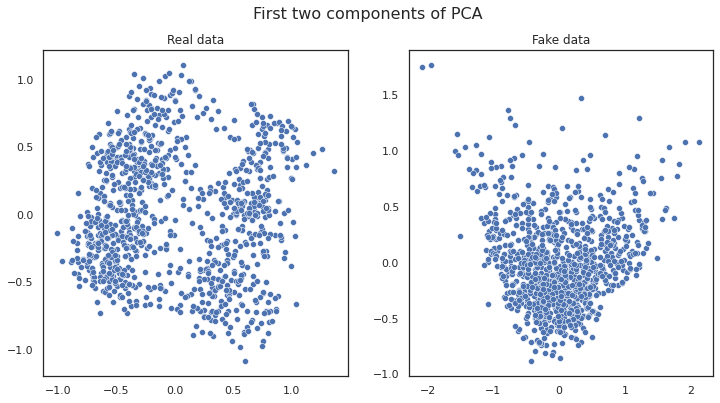



Discriminator Could not detect 92.0/100 of fake samples (they passed as real samples)


In [ ]:
df_not_detected, df_detected = eval_simple_GAN(credit_GAN,credit_df,credit_pipeline)

In [ ]:
df_not_detected

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A12,28.158808,A32,A44,2510.078200,A62,A71,2.567465,A92,A101,2.170944,A123,25.387982,A142,A152,1.138225,A172,1.449446,A191,A201
1,A12,25.904159,A32,A42,3392.453158,A63,A72,2.608807,A93,A101,2.469725,A123,27.748195,A142,A152,1.411411,A172,1.562805,A191,A201
2,A12,18.820132,A32,A44,3453.678450,A63,A72,2.622954,A92,A101,2.053016,A123,40.622357,A143,A152,1.349887,A173,1.555663,A192,A201
3,A12,24.908718,A33,A49,944.736335,A61,A72,3.989634,A92,A101,1.563802,A123,23.053587,A142,A152,0.687150,A173,1.620510,A192,A201
4,A12,37.253288,A32,A40,3596.275134,A62,A72,2.313945,A94,A101,2.690424,A123,37.391007,A143,A152,1.790436,A173,1.791650,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,A13,31.372444,A33,A42,3503.315081,A63,A72,1.952821,A94,A101,2.121305,A123,32.463551,A143,A152,1.800869,A173,1.580961,A191,A201
88,A12,31.939745,A32,A40,2282.052791,A62,A72,1.904318,A93,A101,1.656967,A123,30.940095,A143,A152,1.852071,A173,1.639648,A191,A201
89,A13,36.205432,A34,A49,5260.935285,A62,A72,2.711116,A93,A101,1.210417,A124,38.569977,A142,A152,1.570273,A173,1.721425,A192,A201
90,A12,34.163635,A33,A42,1664.626253,A63,A73,2.320322,A93,A101,3.492985,A123,27.601761,A143,A152,1.675245,A173,1.581448,A191,A201


In [ ]:
df_detected

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A12,20.430773,A32,A40,4207.211351,A63,A72,2.527804,A93,A101,2.701872,A123,26.550917,A143,A152,1.943786,A173,2.029625,A191,A201
1,A13,35.707999,A34,A49,4930.566398,A62,A71,3.797861,A93,A101,0.629707,A124,49.804009,A142,A152,1.737020,A173,1.978126,A192,A201
2,A13,32.548034,A32,A42,2721.266580,A63,A72,2.024817,A93,A101,1.839973,A123,31.511195,A143,A152,1.988378,A172,1.592804,A192,A201
3,A12,40.571706,A31,A40,2470.852460,A64,A72,2.033138,A94,A101,3.345257,A123,48.364063,A143,A152,1.465527,A173,1.751270,A191,A201
4,A13,44.247829,A32,A42,5831.676248,A62,A72,1.924590,A93,A101,2.142959,A124,41.721738,A143,A152,1.527199,A173,1.624792,A192,A201
5,A13,50.166351,A32,A40,5181.322556,A64,A72,2.156181,A94,A101,3.705733,A124,43.540525,A143,A152,2.421761,A173,2.364310,A191,A201
6,A12,32.822167,A32,A44,3141.010488,A63,A72,2.610159,A93,A101,2.667267,A123,36.199594,A143,A152,1.707155,A173,1.576863,A191,A201
7,A12,45.121637,A32,A40,1751.387381,A64,A72,2.078719,A94,A101,3.537075,A123,38.960547,A143,A152,1.711821,A173,2.060917,A191,A201


## diabetes Dataset

### Training

In [ ]:
diabetes_GAN = SimpleGAN(len(diabetes_df.columns))

In [ ]:
diabetes_GAN.summary()

Model: "Simple_GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
Generator (Sequential)       (None, 8)                 672136    
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 21551     
Total params: 693,687
Trainable params: 671,368
Non-trainable params: 22,319
_________________________________________________________________


Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 128)               0         
________________________

In [ ]:
history = diabetes_GAN.train(diabetes_df)

Epoch 0 : Elapsed[2.380 sec] Discriminator[loss: 2.023, acc: 47.135] Generator[loss: 3.276]
Epoch 1 : Elapsed[0.680 sec] Discriminator[loss: 0.691, acc: 50.000] Generator[loss: 0.895]
Epoch 2 : Elapsed[0.708 sec] Discriminator[loss: 0.709, acc: 50.000] Generator[loss: 0.724]
Epoch 3 : Elapsed[0.739 sec] Discriminator[loss: 0.702, acc: 49.935] Generator[loss: 0.716]
Epoch 4 : Elapsed[0.668 sec] Discriminator[loss: 0.698, acc: 49.544] Generator[loss: 0.714]
Epoch 5 : Elapsed[0.710 sec] Discriminator[loss: 0.697, acc: 49.414] Generator[loss: 0.712]
Epoch 6 : Elapsed[0.688 sec] Discriminator[loss: 0.696, acc: 49.609] Generator[loss: 0.709]
Epoch 7 : Elapsed[0.710 sec] Discriminator[loss: 0.695, acc: 49.414] Generator[loss: 0.708]
Epoch 8 : Elapsed[0.738 sec] Discriminator[loss: 0.696, acc: 43.555] Generator[loss: 0.703]
Epoch 9 : Elapsed[0.695 sec] Discriminator[loss: 0.695, acc: 46.940] Generator[loss: 0.704]
Epoch 10 : Elapsed[0.667 sec] Discriminator[loss: 0.694, acc: 47.982] Generator[

### Evaluation

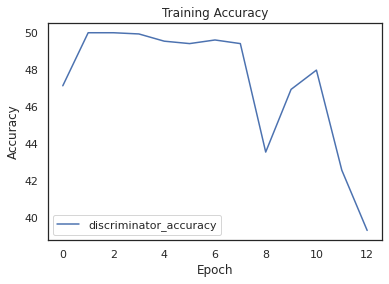

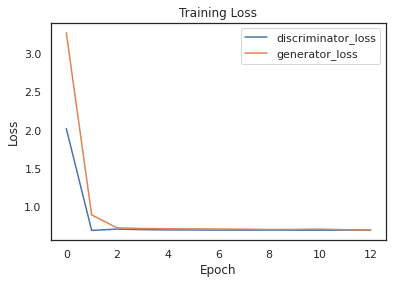

In [ ]:
show_train_history(history)

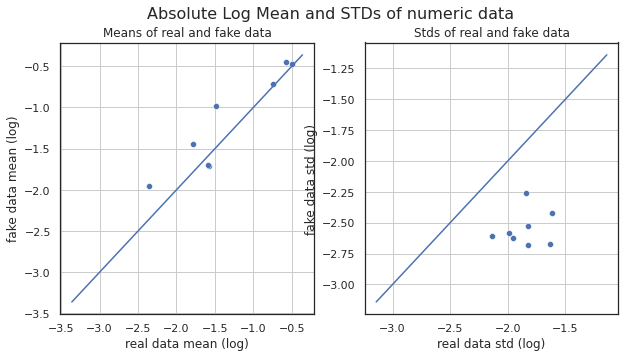

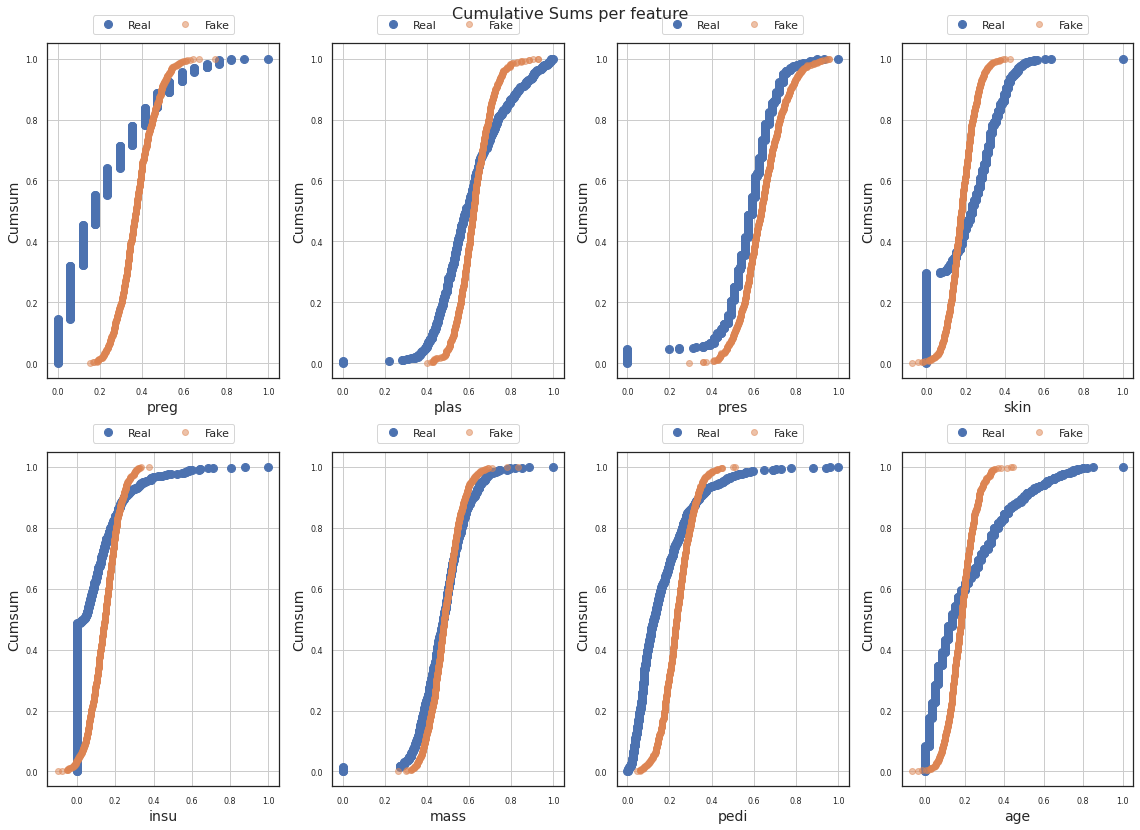

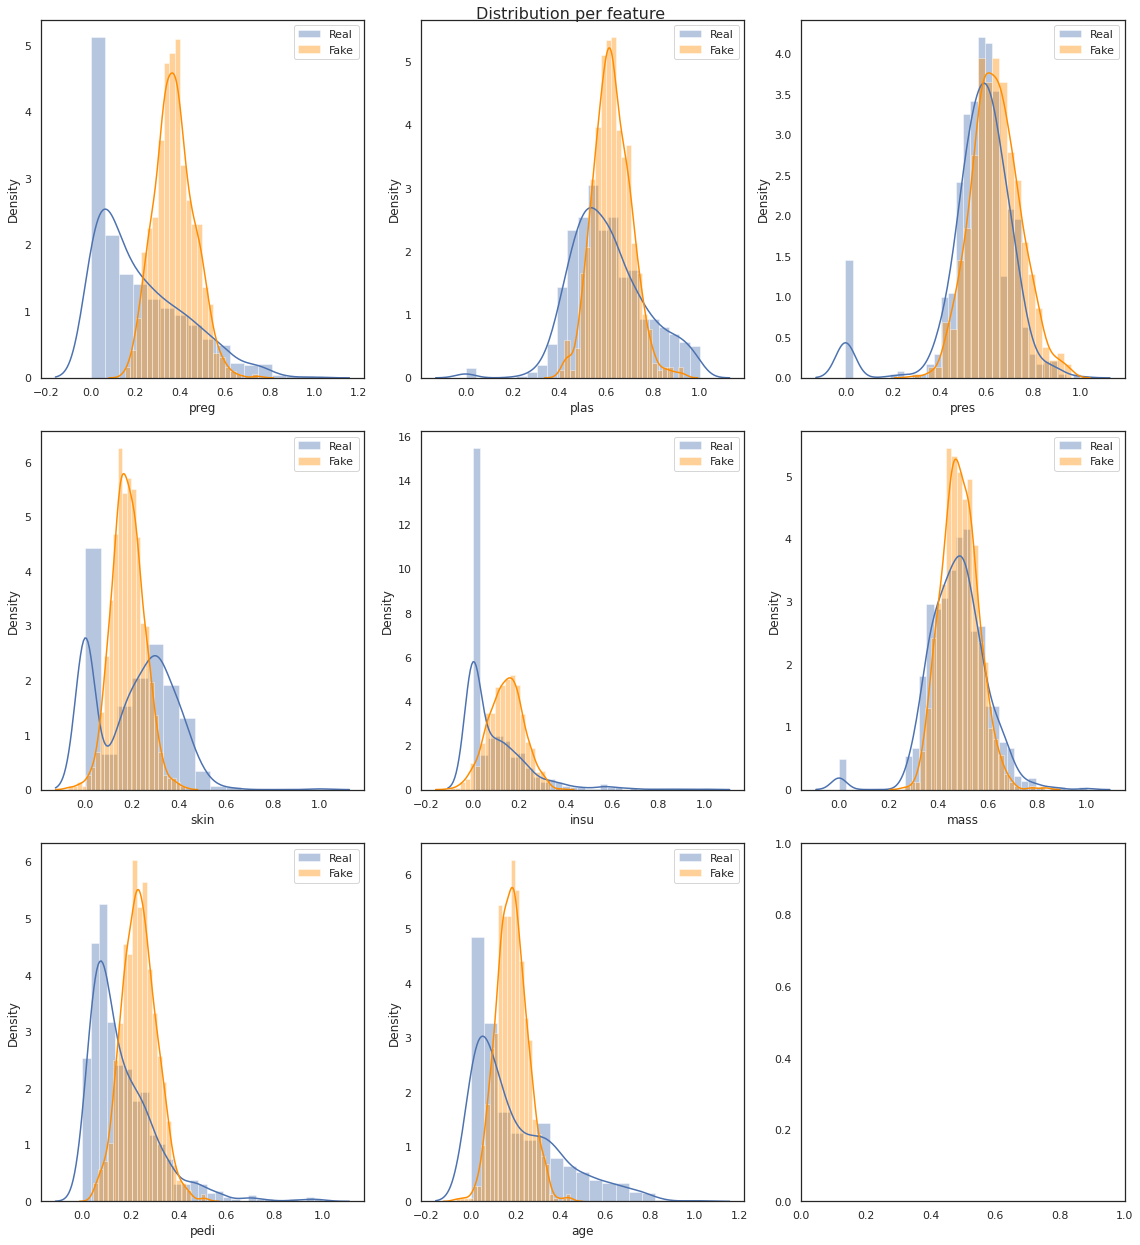

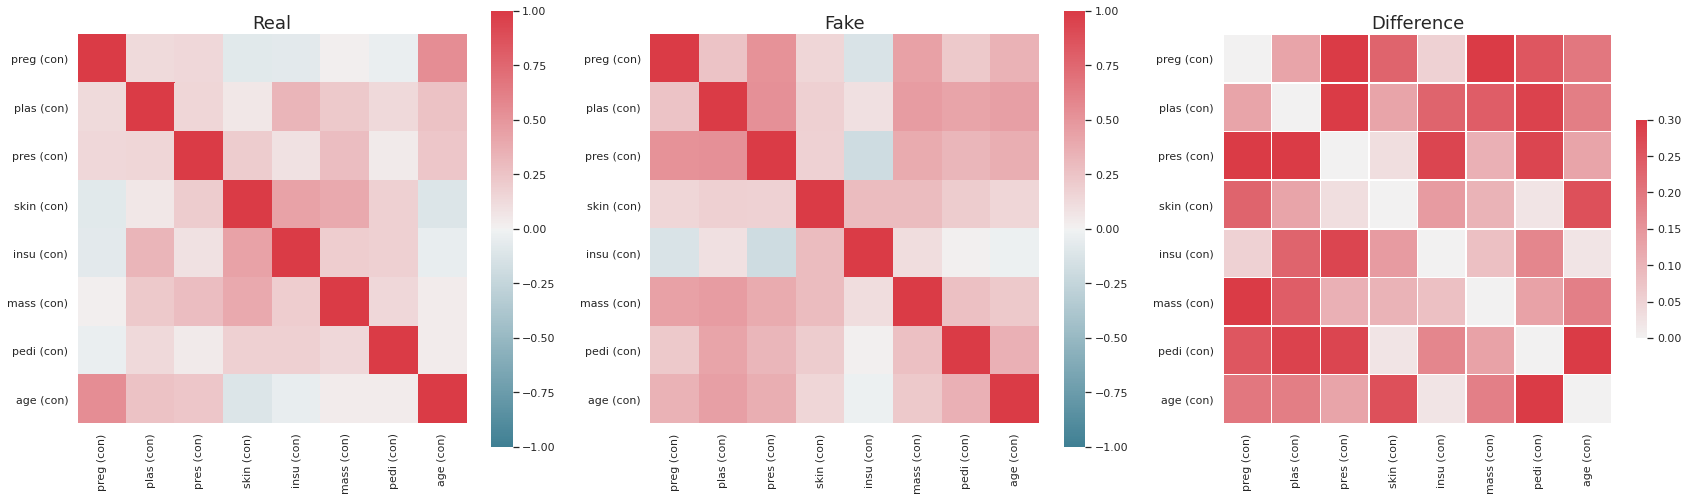

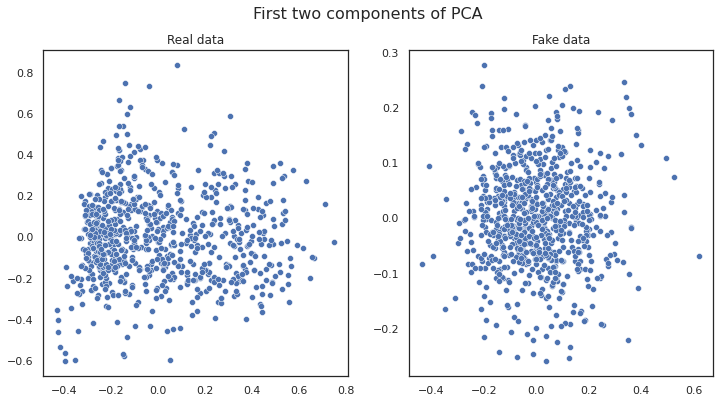



Discriminator Could not detect 77.0/100 of fake samples (they passed as real samples)


In [ ]:
df_not_detected, df_detected = eval_simple_GAN(diabetes_GAN,diabetes_df,diabetes_pipeline)

In [ ]:
df_not_detected

,preg,plas,pres,skin,insu,mass,pedi,age
0,8.165651,147.890320,106.170731,33.207184,182.323975,39.635353,0.766945,35.010338
1,6.222861,124.716270,67.672691,6.345923,2.158383,32.456367,0.642148,36.771709
2,6.046867,118.507858,61.574181,17.915689,106.299675,31.114388,0.612199,29.848770
3,5.946992,118.172844,86.020935,14.159040,124.610771,33.534145,0.548010,30.454781
4,3.726823,125.816200,57.956280,27.603296,206.778442,29.326351,0.741517,29.889612
...,...,...,...,...,...,...,...,...
72,5.371991,113.474541,78.460609,16.179331,151.865524,33.409309,0.433848,34.138359
73,6.126807,135.870575,88.224663,22.089909,104.692650,38.005875,0.473856,26.952473
74,6.572417,140.722153,68.107254,30.748377,119.491737,29.875326,0.924568,39.867302
75,5.647562,111.732513,78.386490,28.594513,81.093277,25.944904,0.525860,41.325436


In [ ]:
df_detected

,preg,plas,pres,skin,insu,mass,pedi,age
0,3.825327,120.617050,66.720772,16.784134,97.419716,24.153133,0.726621,26.477320
1,6.679574,133.684067,63.511139,21.884069,184.282333,34.071747,0.866677,25.510733
2,5.325947,122.595573,74.229065,12.857276,13.792734,32.038677,0.617848,31.556896
3,2.244294,123.206116,92.985626,7.530468,79.542542,30.772444,0.431509,25.137123
4,5.189707,142.378586,88.351051,20.974493,47.867393,36.139214,0.738092,37.604458
5,6.980682,118.927155,87.228752,21.597584,26.200556,42.783531,0.733048,27.307396
6,5.581544,161.764740,88.269463,17.777782,107.267982,44.329227,0.679132,31.981434
7,4.099951,99.727692,47.869240,18.614868,118.418129,28.572245,0.596658,27.120100
8,4.513251,130.067612,68.835442,9.563777,107.518448,31.025543,0.633547,33.962791
9,8.559807,153.397171,98.366707,21.230030,35.202229,36.001259,0.598672,33.424694


# Part 2 - Black-Box Generative Adversarial Networks (GAN)

---

inferring the inner-working of a black-box model (a model trained on some data of which you have no access).

In [ ]:
bbox_gan_parameters = {
    "batch_size" : 128,
    "batch_per_epoch" : 10,
    "verbose": 1,
    "gen_dim": 256,
    "disc_dim": 50,
    "loss": 'binary_crossentropy',
    "noise_dim": 128,
    "epochs" : 1000,
    "optimizer": Adam(5e-4 , 0.5),
    "metrics": ['accuracy'],
    "early_stop_wait": 10
}

## Black Box Model

In [ ]:
def get_BBOX_model(df,model=RandomForestClassifier()):
  """
  Fit a Black Box Model base on a given model and dataset
  the data set will be split to train/test (70% / 30%)
  
  :param df: dataframe, the dataset to fit the model
  :param model: a given black box model, default is RandomForest
  :return: 
    bbox_model: the fitted black box model
    test_set: the test set to help evaluate it
  """
  # prepare dataset
  train, test = train_test_split(df, test_size=0.3)

  cols = df.columns
  n_cols = len(cols)

  X_train = train[cols[:n_cols - 1]]
  y_train = train[cols[n_cols - 1]]
  X_test = test[cols[:n_cols - 1]]
  y_test = test[cols[n_cols - 1]]

  # fit bbox model
  bbox_model = model
  bbox_model.fit(X_train,y_train)

  return bbox_model, (X_test,y_test)

## Model

### Generator

In [ ]:
def get_bbox_generator(dim, gen_data_dim):
  """
  Get the Generator Model

  :param dim: number of feature of the data
  :param gen_data_dim: generator inner Dense size
  :return: 
    generator: keras model
  """
  
  generator = Sequential(name = 'Generator')
  
  generator.add(Dense(dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(dim * 2))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(dim * 3))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Dense(dim * 4))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(Dense(gen_data_dim))

  return generator

### Discriminator

In [ ]:
def get_bbox_discriminator(dim):
  """
  Get the Discriminator Model

  :param dim: discriminator inner Dense size
  :return: 
    discriminator: keras model
  """
  discriminator = Sequential(name = 'Discriminator')
  
  discriminator.add(Dense(dim * 3, activation='relu'))
  discriminator.add(Dropout(0.1))
  discriminator.add(Dense(dim * 2, activation='relu'))
  discriminator.add(Dropout(0.1))
  discriminator.add(Dense(dim, activation='relu'))
  discriminator.add(Dense(1, activation='sigmoid'))

  return discriminator

### BBOX GAN

In [ ]:
class BBoxGan():
  """
  Generative Adversarial Networks (GAN) that infer the inner-working of a black-box model  
  """
  def __init__(self,data_dim,bbox_model,gen_builder=get_bbox_generator,disc_builder=get_bbox_discriminator,parameters=bbox_gan_parameters):
    """
    Constructor

    :param data_dim: int, number of features of the generated data
    :param bbox_model: ml model, black-box that the GAN will infer
    :param gen_builder: generator build function
    :param disc_builder: discriminator build function
    :param parameters: dict, model hyper parameters
    """
    self.data_dim = data_dim
    self.parameters = parameters
    self.bbox_model = bbox_model

    model, generator, discriminator = BBoxGan.build_model(data_dim,bbox_model,gen_builder,disc_builder,parameters)

    self.model = model
    self.generator = generator
    self.discriminator = discriminator

  def build_model(data_dim,bbox_model,gen_builder,disc_builder,parameters):
    """
    Static Class Method, Build a Black-Box GAN model base on a given parameters

    :param data_dim: int, number of features of the generated data
    :param bbox_model: ml model, black-box that the GAN will infer
    :param gen_builder: generator build function
    :param disc_builder: discriminator build function
    :param parameters: dict, model hyper parameters
    :return: 
        model: keras model, the GAN model
        generator: keras model, the generator model
        discriminator: keras model, the discriminator model
    """

    # Generator
    gen_noise_input = Input(parameters["noise_dim"],name="Generator_noise_input")
    gen_confidence_input = Input(1,name="Generator_confidence_input")

    concat_gen_in_layer = Concatenate()([gen_noise_input,gen_confidence_input])

    sample = gen_builder(parameters["gen_dim"],data_dim)(concat_gen_in_layer)
    
    generator_model = Model(inputs=[gen_noise_input,gen_confidence_input],outputs=sample, name="Generator")
    generator_model.trainable = False

    # Discriminator
    disc_confidence_input = Input(1,name="Discriminator_confidence_input")
    disc_sample_input = Input(data_dim,name="Discriminator_sample_input")

    concat_disc_in_layer = Concatenate()([disc_sample_input,disc_confidence_input])
    
    validity = disc_builder(parameters["disc_dim"])(concat_disc_in_layer)

    discriminator_model = Model(inputs=[disc_sample_input,disc_confidence_input],outputs=validity, name="Discriminator")
    discriminator_model.compile(loss=parameters["loss"],optimizer=parameters["optimizer"],metrics=parameters["metrics"])
    
    # BBOX GAN MODEL
    # For the combined model we will only train the generator - (we already compiled the discriminator to use as the first step)
    discriminator_model.trainable = False
    generator_model.trainable = True

    gen_sample_validity = discriminator_model([sample,disc_confidence_input])

    model = Model(inputs=[gen_noise_input,gen_confidence_input,disc_confidence_input], outputs=gen_sample_validity,name='BBox_GAN')
    model.compile(loss=parameters["loss"], optimizer=parameters["optimizer"])

    return model, generator_model, discriminator_model

  def train(self):
    """
    Fit the GAN model

    :return:
      history: tuple, with training history information 
    """
    batch_size = self.parameters["batch_size"]
    n_batch_per_epoch = self.parameters["batch_per_epoch"]

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    start_t = time.time()
    
    discriminator_loss = []
    generator_loss = []
    discriminator_acc = []

    best_disc_loss = float('inf')
    disc_loss_no_change = 0
    best_gen_loss = float('inf')
    gen_loss_no_change = 0

    for epoch_id in range(self.parameters["epochs"]):

      generator_loss_list = np.empty(n_batch_per_epoch)
      discriminator_loss_list = np.empty(n_batch_per_epoch)
      discriminator_acc_list = np.empty(n_batch_per_epoch)

      start_e = time.time()

      for batch_id in range(n_batch_per_epoch):
        
        # prepare batch data
        noise = np.random.normal(0, 1, (batch_size, self.parameters["noise_dim"]))
        c = np.random.uniform(0,1,batch_size)

        samples = self.generator.predict([noise,c])
        bbox_c = self.bbox_model.predict_proba(samples)[:,1]

        # 1 for valid confidence (from bbox on this sample), 0 for fake confidence (random to generate this sample)
        batch_c = np.empty(batch_size)
        batch_label = np.empty(batch_size)
        randoms = np.random.uniform(0,1,batch_size)
        for i in range(batch_size):
            batch_c[i] = c[i] if randoms[i] <= 0.5 else bbox_c[i]
            batch_label[i] = 0 if randoms[i] <= 0.5 else 1
      
        # First Step = discriminator training
        d_loss = self.discriminator.train_on_batch([samples,batch_c], batch_label)
        
        discriminator_loss_list[batch_id] = d_loss[0]
        discriminator_acc_list[batch_id] = 100 * d_loss[1]

        # Second Step = generator training
        generator_loss_list[batch_id] = self.model.train_on_batch([noise,c,batch_c], batch_label)

      disc_epoch_loss = discriminator_loss_list.mean()
      gen_epoch_loss = generator_loss_list.mean()
      disc_epoch_acc = discriminator_acc_list.mean()

      discriminator_loss.append(disc_epoch_loss)
      generator_loss.append(gen_epoch_loss)
      discriminator_acc.append(disc_epoch_acc)
      if epoch_id % self.parameters["verbose"] == 0:
        print("Epoch {0:} : Elapsed[{1:1.3f} sec] Discriminator[loss: {2:1.3f}, acc: {3:1.3f}] Generator[loss: {4:1.3f}]".format(epoch_id,round(time.time()-start_e,3) ,round(discriminator_loss_list.mean(),3), round(discriminator_acc_list.mean(),3), round(generator_loss_list.mean(),3)))

      if disc_epoch_loss < best_disc_loss:
        best_disc_loss = disc_epoch_loss
        disc_loss_no_change = 0
      else:
        disc_loss_no_change += 1

      if gen_epoch_loss < best_gen_loss:
        best_gen_loss = gen_epoch_loss
        gen_loss_no_change = 0
      else:
        gen_loss_no_change += 1

      # early stop if both generator, discriminator not improved
      if disc_loss_no_change > self.parameters["early_stop_wait"] and gen_loss_no_change > self.parameters["early_stop_wait"]:
        break

    print("Fit Time = {} sec".format(round(time.time() - start_t,3)))
    return discriminator_acc, discriminator_loss, generator_loss

  def generate_samples(self,n=1000,min_c=0,max_c=1):
    """
    Generate GAN samples

    :param n: number of samples to generate
    :param min_c: minimum confidence value, default = 0
    :param max_c: maximum confidence value, default = 1
    :return: 
      samples: ndarray shape of (n,data_dim)
      confidence: confidence input that was used to generate each sample
    """
    noise = np.random.normal(min_c,max_c, (n, self.parameters["noise_dim"]))
    c=np.random.uniform(min_c,max_c,n)

    return self.generator.predict([noise,c]), c

  def plot(self):
    """
    Plot the GAN model
    """
    imageName = "model.png"
    plot_model(self.model,to_file=imageName,show_shapes=True)
    display(Image(filename=imageName))

  def summary(self):
    """
    Print Summary of the GAN model and its Components
    """
    self.model.summary()
    print()
    print("=" * 100)
    print()
    self.generator.summary()
    print()
    print("-" * 100)
    print()
    self.discriminator.summary()
    print()
    print("=" * 100)

## Evaluation

In [ ]:
def eval_bbox(bbox_model,test_set):
  """
  Evaluate the black-box base on a given test set
  The RandomForest classifier’s performance – in terms of confidence score distribution – for
  the 30% test set. Provide min/max/average, as well as a figure showing the distribution

  :param bbox_model: ML balck-box model to evaluate
  :param test_set: test set samples
  """
  X_test, y_test = test_set

  plt.hist(y_test,bins=[0,0.5,1])
  plt.xlabel('Label')
  plt.title("Test Set Labels Distribution")
  plt.ylabel('Count')
  plt.show()
  print()

  test_acc = bbox_model.score(X_test,y_test)
  prd = bbox_model.predict(X_test)
  
  print("Black Box Test Information:\nTest Accuracy = {}\nPredictions (Confidence Scores): [min={},avg={},max={}]".format(test_acc,prd.min(),prd.mean(),prd.max()))
  print()

  plt.hist(bbox_model.predict_proba(X_test)[:,1])
  plt.xlabel('Prediction (Confidence Score)')
  plt.title("Predictions Distribution")
  plt.ylabel('Count')
  plt.show()


In [ ]:
def eval_bbox_GAN(model,df,pipeline):
  """
  Evaluate the Black-Box GAN model

  :param model: BBoxGAN, GAN model to evaluate
  :param df: test data set samples
  :param pipeline: pre-process pipeline that was generated from 'preprocess_tabular_df' 
  :return: 
    generated_samples: dataframe, generated samples from the GAN model
  """

  generated_samples, generated_c = model.generate_samples()
  bbox_c = model.bbox_model.predict_proba(generated_samples)[:,1]

  bin = np.arange(0,1,0.05)
  plt.hist(bbox_c,bins=bin)
  plt.xlabel('C - Confidence Score')
  plt.ylabel('Count')
  plt.title("Generated Black Box score Distribution")
  plt.show()

  plt.hist(generated_c,bins=bin)
  plt.xlabel('C - Confidence Score')
  plt.ylabel('Count')
  plt.title("Generated Uniform Random Sampled C Distribution")
  plt.show()
  print()

  generated_c_label = generated_c.copy()
  generated_c_label[generated_c_label <= 0.5] = 0
  generated_c_label[generated_c_label > 0.5] = 1
  bbox_c_label = bbox_c.copy()
  bbox_c_label[bbox_c_label <= 0.5] = 0
  bbox_c_label[bbox_c_label > 0.5] = 1

  plt.hist(generated_c_label,bins=[0,0.5,1])
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title("Generated Uniform Random Sampled Label Distribution")
  plt.show()

  plt.hist(bbox_c_label,bins=[0,0.5,1])
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title("Generated Black Box score Label Distribution")
  plt.show()
  
  print()

  acc = 1 - (np.abs(generated_c_label - bbox_c_label).sum() / len(generated_c_label)) 
  mse = np.square(generated_c - bbox_c).mean()
  
  print("=" * 40)
  print()
  print("MSE Score (Diffrence between sampled C and BBox C): {}\nAccuracy (C round As Label): {}".format(round(mse,3),round(acc,3)))
  print()
  print("=" * 40)

  print()

  generated_samples, generated_c = model.generate_samples(300)
  bbox_c = model.bbox_model.predict_proba(generated_samples)[:,1]
  generated_samples_df = pd.DataFrame(generated_samples,columns=df.columns)

  table_evaluator = TableEvaluator(df, generated_samples_df)
  
  print()
  table_evaluator.visual_evaluation()
  print()

  return inverse_preprocess_to_tabular(generated_samples_df,pipeline)

## german_credit Dataset

In [ ]:
credit_bbox_model, credit_test_set = get_BBOX_model(credit_df_bbox)

### Training

In [ ]:
credit_BBox_GAN = BBoxGan(len(credit_df.columns),credit_bbox_model)

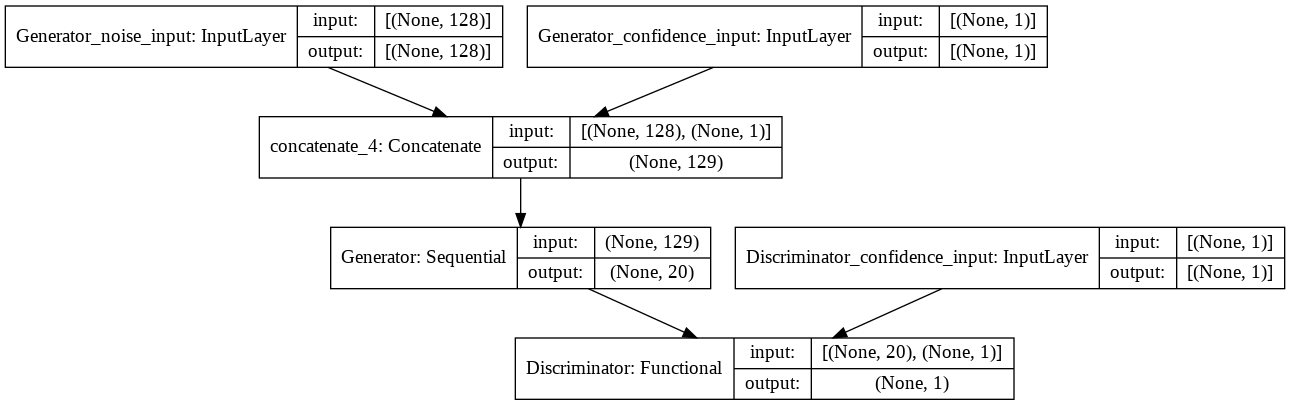

In [ ]:
credit_BBox_GAN.plot()

In [ ]:
credit_BBox_GAN.summary()

Model: "BBox_GAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_noise_input (InputLay [(None, 128)]        0                                            
__________________________________________________________________________________________________
Generator_confidence_input (Inp [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 129)          0           Generator_noise_input[0][0]      
                                                                 Generator_confidence_input[0][0] 
__________________________________________________________________________________________________
Generator (Sequential)          (None, 20)           1369876     concatenate_4[0][0]       

In [ ]:
history = credit_BBox_GAN.train()

Epoch 0 : Elapsed[2.872 sec] Discriminator[loss: 0.697, acc: 47.812] Generator[loss: 0.701]
Epoch 1 : Elapsed[1.474 sec] Discriminator[loss: 0.701, acc: 49.375] Generator[loss: 0.693]
Epoch 2 : Elapsed[1.424 sec] Discriminator[loss: 0.704, acc: 49.375] Generator[loss: 0.693]
Epoch 3 : Elapsed[1.371 sec] Discriminator[loss: 0.711, acc: 49.141] Generator[loss: 0.698]
Epoch 4 : Elapsed[1.434 sec] Discriminator[loss: 0.702, acc: 51.406] Generator[loss: 0.694]
Epoch 5 : Elapsed[1.324 sec] Discriminator[loss: 0.714, acc: 49.844] Generator[loss: 0.698]
Epoch 6 : Elapsed[1.322 sec] Discriminator[loss: 0.701, acc: 52.031] Generator[loss: 0.687]
Epoch 7 : Elapsed[1.335 sec] Discriminator[loss: 0.702, acc: 50.312] Generator[loss: 0.701]
Epoch 8 : Elapsed[1.405 sec] Discriminator[loss: 0.707, acc: 50.469] Generator[loss: 0.690]
Epoch 9 : Elapsed[1.399 sec] Discriminator[loss: 0.698, acc: 51.016] Generator[loss: 0.692]
Epoch 10 : Elapsed[1.345 sec] Discriminator[loss: 0.702, acc: 49.766] Generator[

### Evaluation

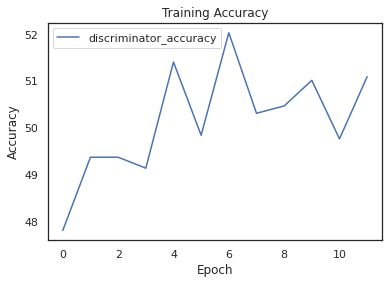

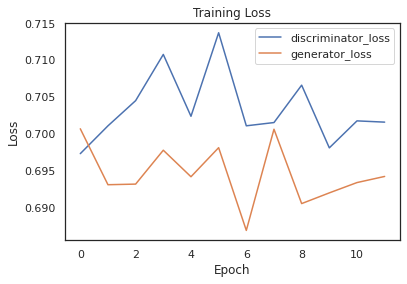

In [ ]:
show_train_history(history)

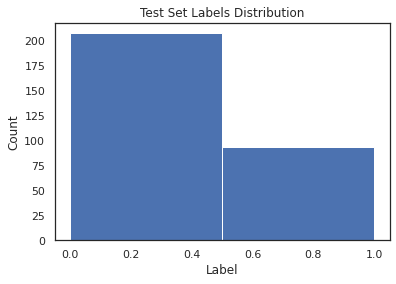


Black Box Test Information:
Test Accuracy = 0.7666666666666667
Predictions (Confidence Scores): [min=0,avg=0.19666666666666666,max=1]



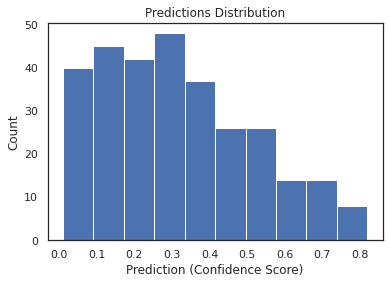

In [ ]:
eval_bbox(credit_bbox_model, credit_test_set)

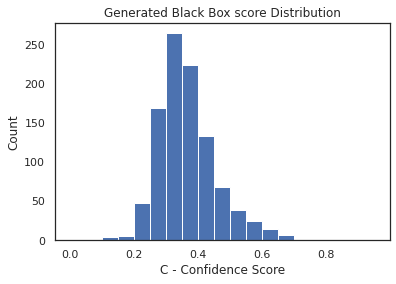

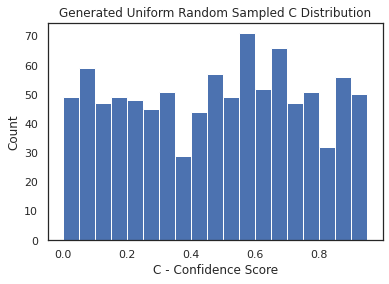

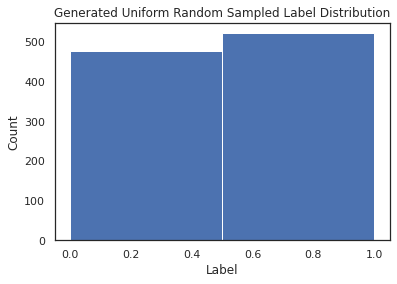

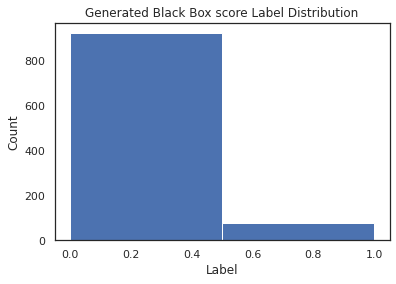



MSE Score (Diffrence between sampled C and BBox C): 0.106
Accuracy (C round As Label): 0.489





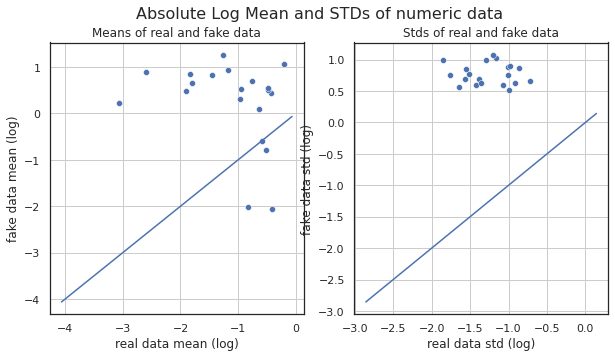

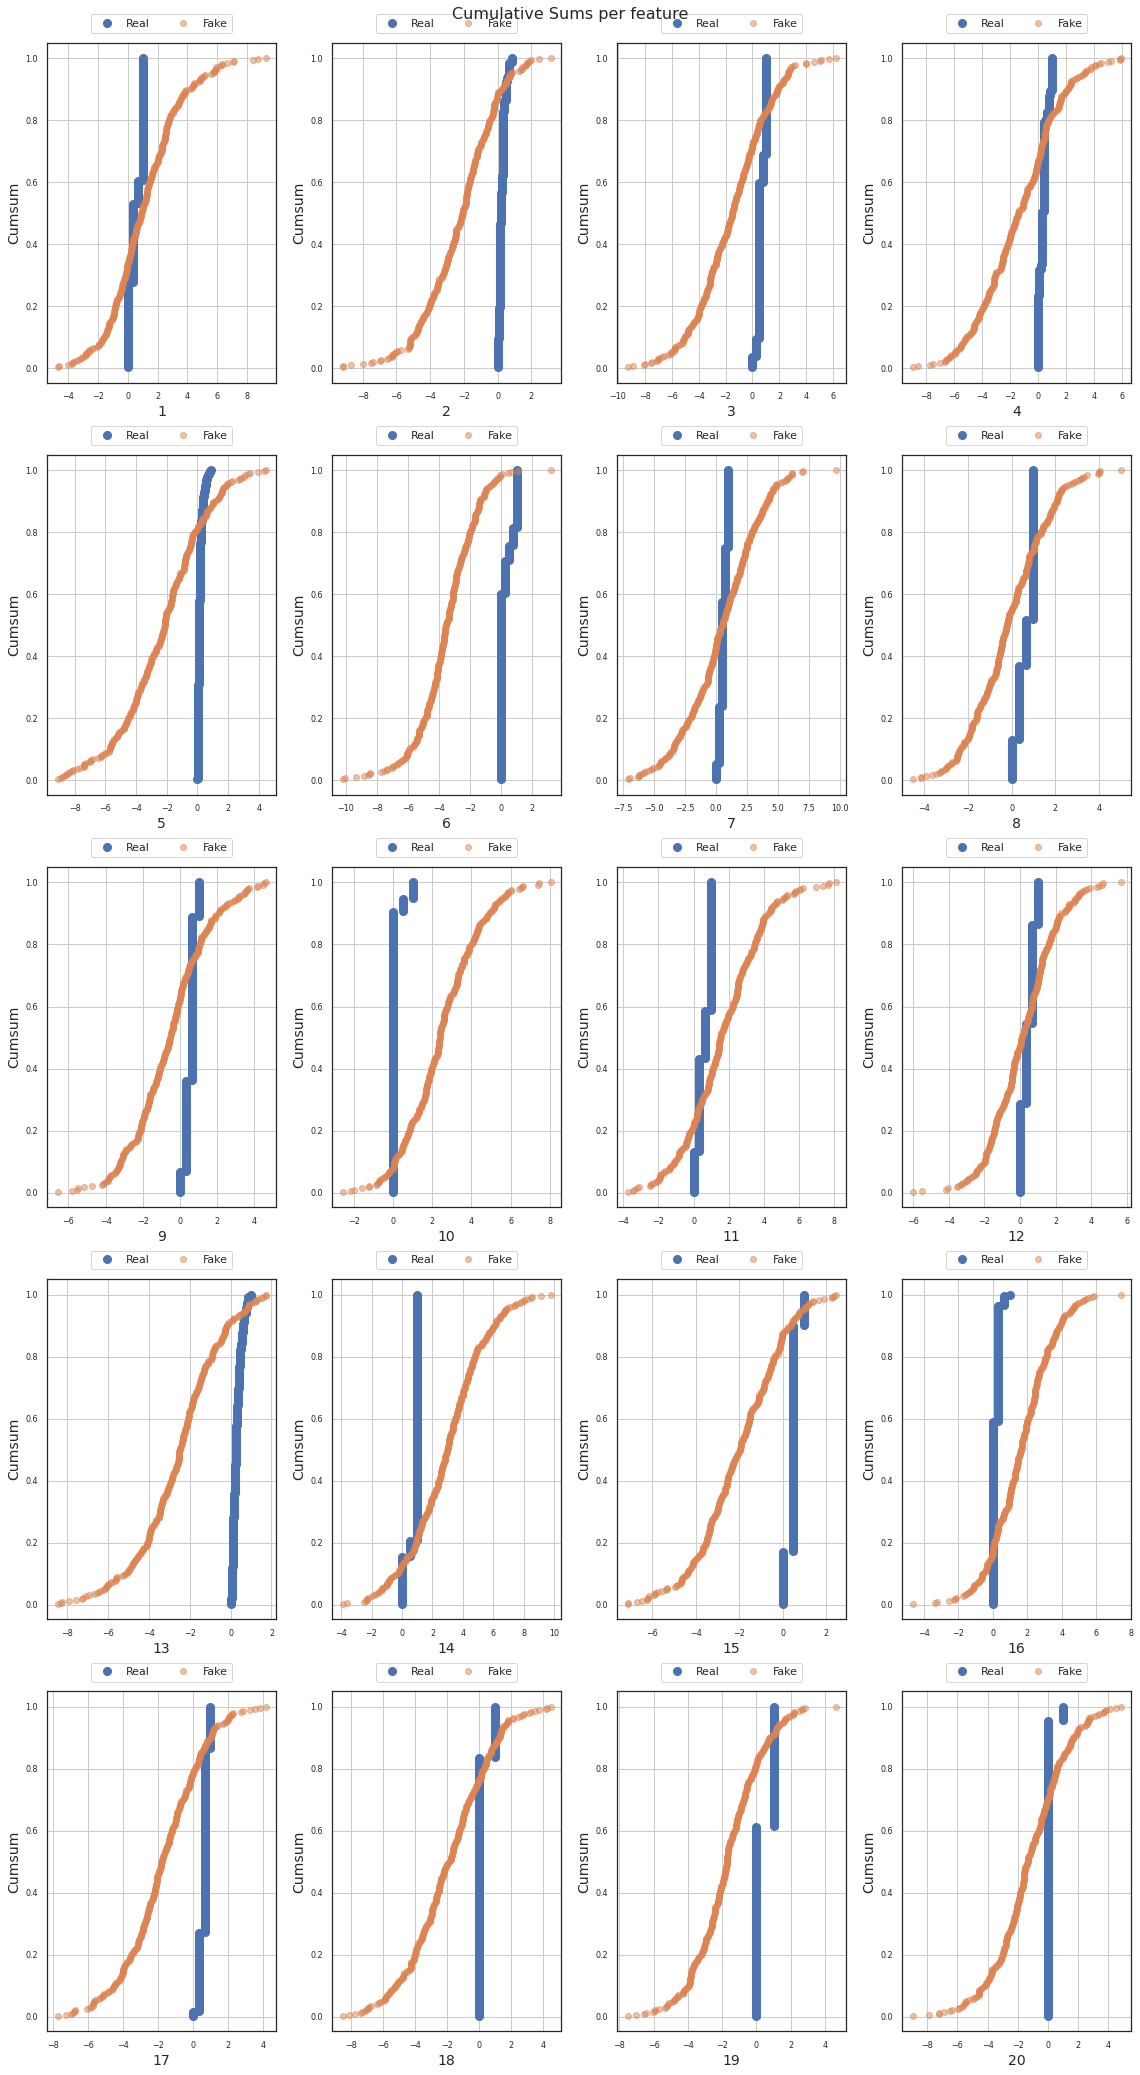

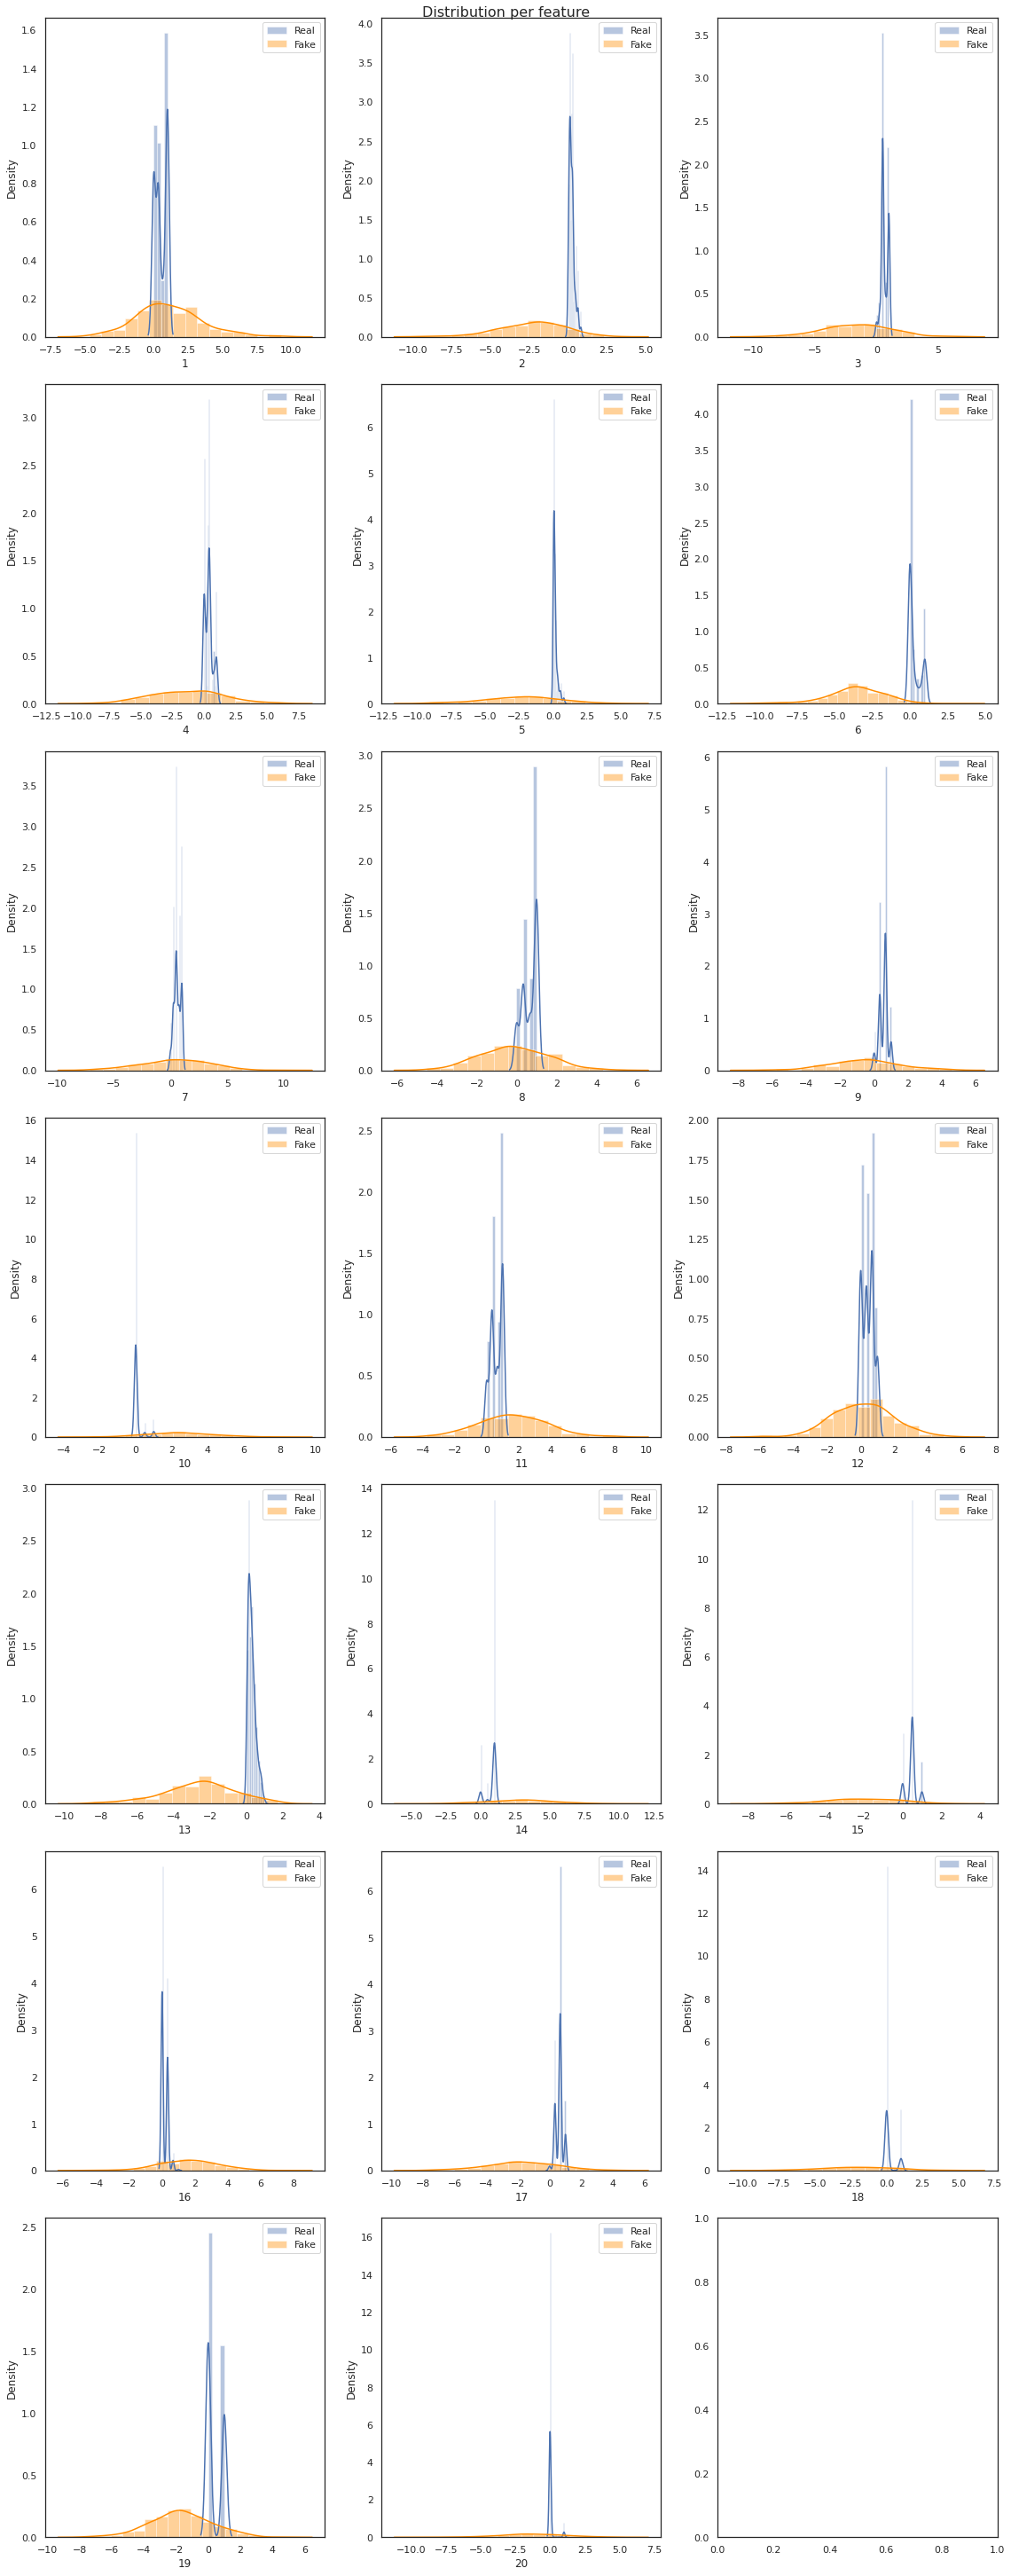

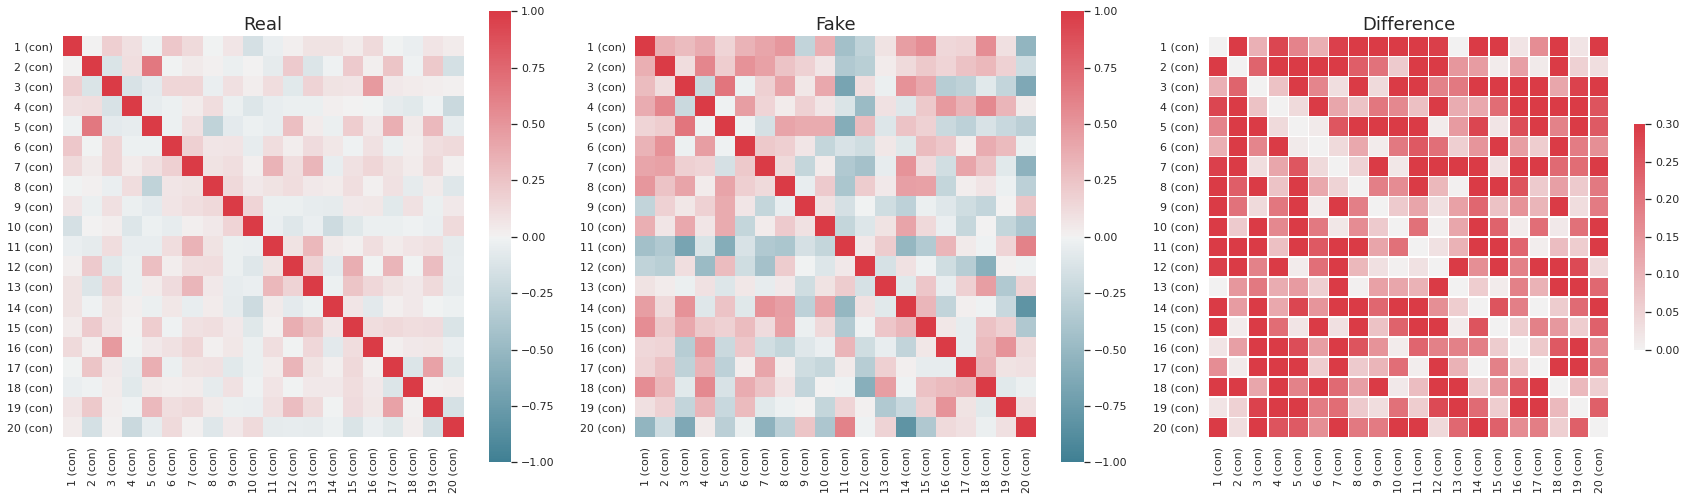

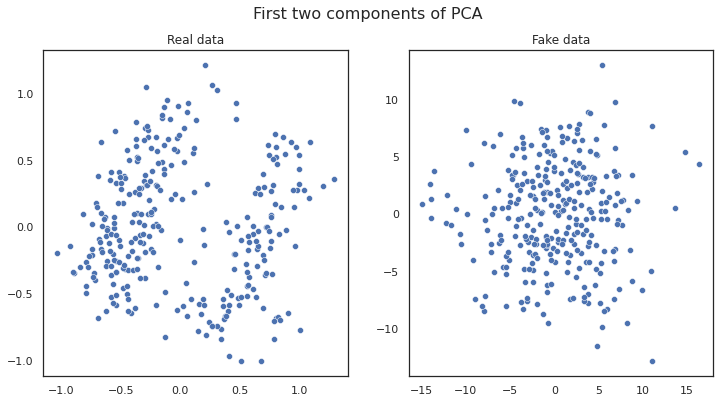

In [ ]:
generated_samples = eval_bbox_GAN(credit_BBox_GAN,credit_df,credit_pipeline)

In [ ]:
generated_samples

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A14,-107.429785,A30,A49,-94376.866352,A61,A75,0.896924,A91,A103,0.129769,A122,-387.853024,A143,A151,8.430396,A172,-1.707462,A192,A201
1,A11,-348.080912,A30,A40,-38590.794644,A61,A71,-10.718340,A94,A102,6.654971,A121,-453.698776,A141,A151,5.647251,A171,-4.634257,A191,A201
2,A14,-50.362838,A30,A40,-11454.402529,A61,A72,4.494296,A91,A103,1.115757,A124,-315.149544,A143,A151,6.455552,A171,-0.729062,A191,A201
3,A13,-332.178074,A30,A40,-157613.174700,A61,A71,-11.378934,A91,A102,16.185609,A122,-121.490318,A143,A151,11.266793,A171,-0.608026,A191,A201
4,A11,-241.346402,A31,A40,30322.969176,A61,A71,-3.364721,A94,A103,5.226161,A124,-95.961296,A143,A151,8.596582,A171,-3.679269,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,A14,-286.114931,A30,A49,-5833.045032,A61,A71,-1.827873,A91,A103,1.750750,A124,-118.492559,A143,A151,10.825123,A171,1.473581,A191,A201
296,A14,47.602253,A30,A49,-38253.902397,A61,A75,6.879375,A91,A103,3.412791,A121,-42.130024,A143,A151,5.343840,A174,2.793517,A191,A202
297,A14,-96.783384,A32,A40,9682.779270,A61,A75,3.168544,A91,A103,0.662338,A121,-123.902069,A143,A151,2.933672,A171,0.696071,A191,A201
298,A11,48.085502,A34,A40,55102.522709,A61,A71,9.965626,A92,A102,-2.300155,A124,-295.427731,A143,A151,5.828803,A171,-4.842980,A191,A201


## diabetes Dataset

In [ ]:
diabetes_bbox_model, diabetes_test_set = get_BBOX_model(diabetes_df_bbox)

### Training

In [ ]:
diabetes_BBox_GAN = BBoxGan(len(diabetes_df.columns),diabetes_bbox_model)

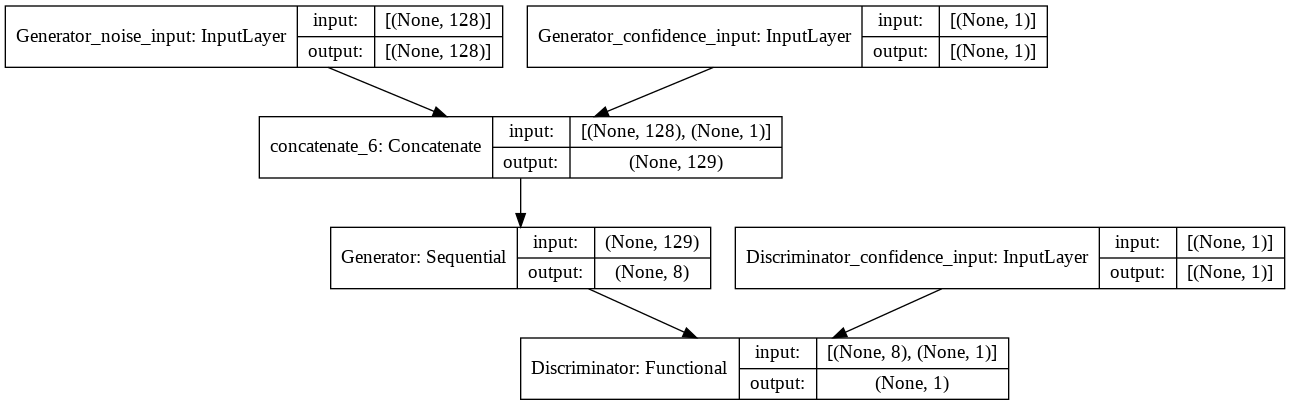

In [ ]:
diabetes_BBox_GAN.plot()

In [ ]:
diabetes_BBox_GAN.summary()

Model: "BBox_GAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_noise_input (InputLay [(None, 128)]        0                                            
__________________________________________________________________________________________________
Generator_confidence_input (Inp [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 129)          0           Generator_noise_input[0][0]      
                                                                 Generator_confidence_input[0][0] 
__________________________________________________________________________________________________
Generator (Sequential)          (None, 8)            1357576     concatenate_6[0][0]       

In [ ]:
history = diabetes_BBox_GAN.train()

Epoch 0 : Elapsed[2.895 sec] Discriminator[loss: 0.710, acc: 52.500] Generator[loss: 0.749]
Epoch 1 : Elapsed[1.367 sec] Discriminator[loss: 0.717, acc: 51.953] Generator[loss: 0.708]
Epoch 2 : Elapsed[1.775 sec] Discriminator[loss: 0.710, acc: 50.859] Generator[loss: 0.698]
Epoch 3 : Elapsed[1.383 sec] Discriminator[loss: 0.701, acc: 52.500] Generator[loss: 0.689]
Epoch 4 : Elapsed[1.356 sec] Discriminator[loss: 0.702, acc: 51.719] Generator[loss: 0.694]
Epoch 5 : Elapsed[1.377 sec] Discriminator[loss: 0.703, acc: 50.312] Generator[loss: 0.694]
Epoch 6 : Elapsed[1.330 sec] Discriminator[loss: 0.694, acc: 51.641] Generator[loss: 0.691]
Epoch 7 : Elapsed[1.446 sec] Discriminator[loss: 0.698, acc: 51.875] Generator[loss: 0.688]
Epoch 8 : Elapsed[1.345 sec] Discriminator[loss: 0.711, acc: 48.359] Generator[loss: 0.695]
Epoch 9 : Elapsed[1.362 sec] Discriminator[loss: 0.695, acc: 52.500] Generator[loss: 0.695]
Epoch 10 : Elapsed[1.388 sec] Discriminator[loss: 0.699, acc: 50.859] Generator[

### Evaluation

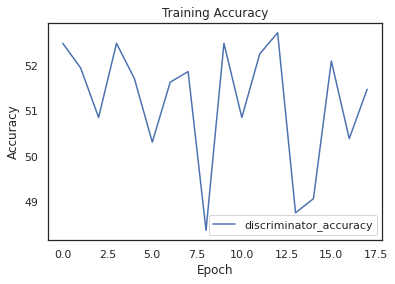

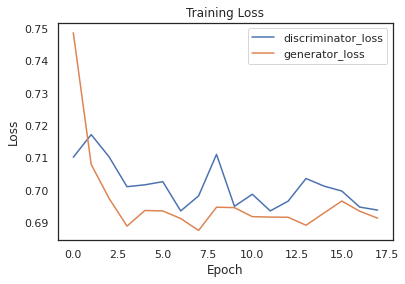

In [ ]:
show_train_history(history)

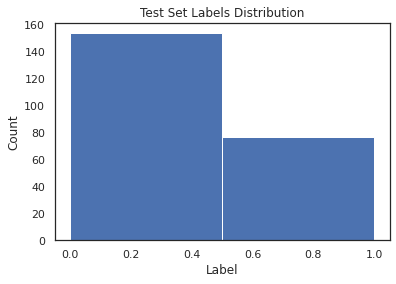


Black Box Test Information:
Test Accuracy = 0.7359307359307359
Predictions (Confidence Scores): [min=0,avg=0.3203463203463203,max=1]



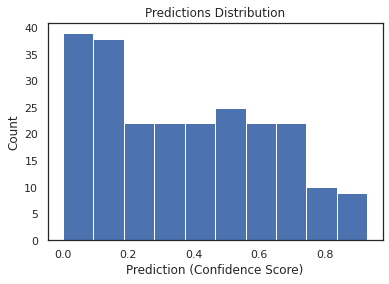

In [ ]:
eval_bbox(diabetes_bbox_model, diabetes_test_set)

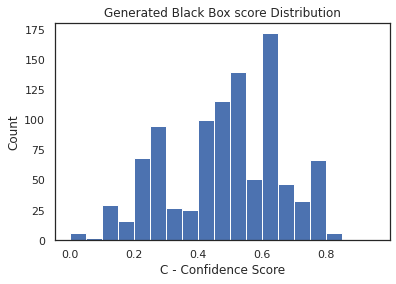

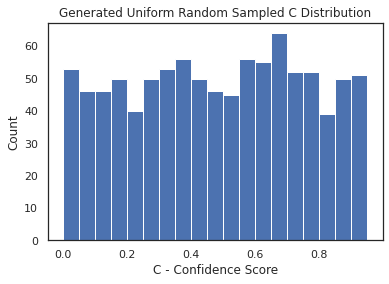

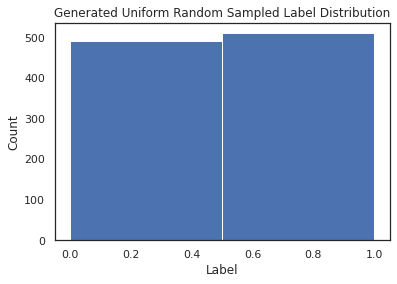

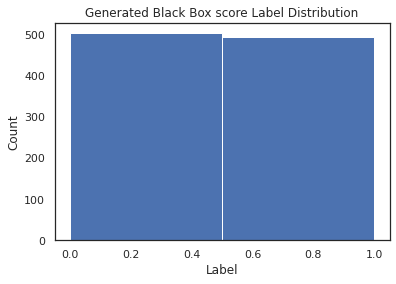



MSE Score (Diffrence between sampled C and BBox C): 0.114
Accuracy (C round As Label): 0.486





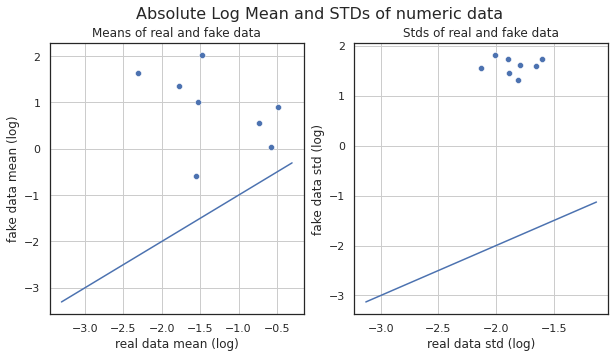

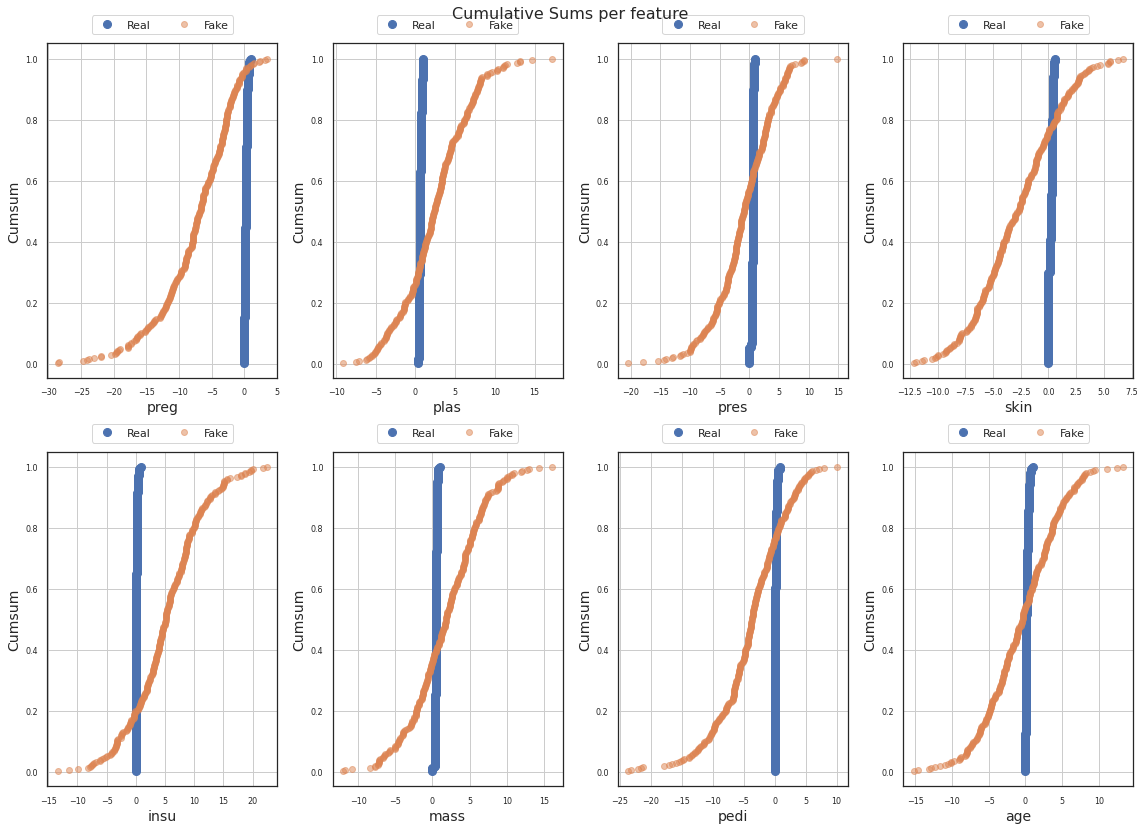

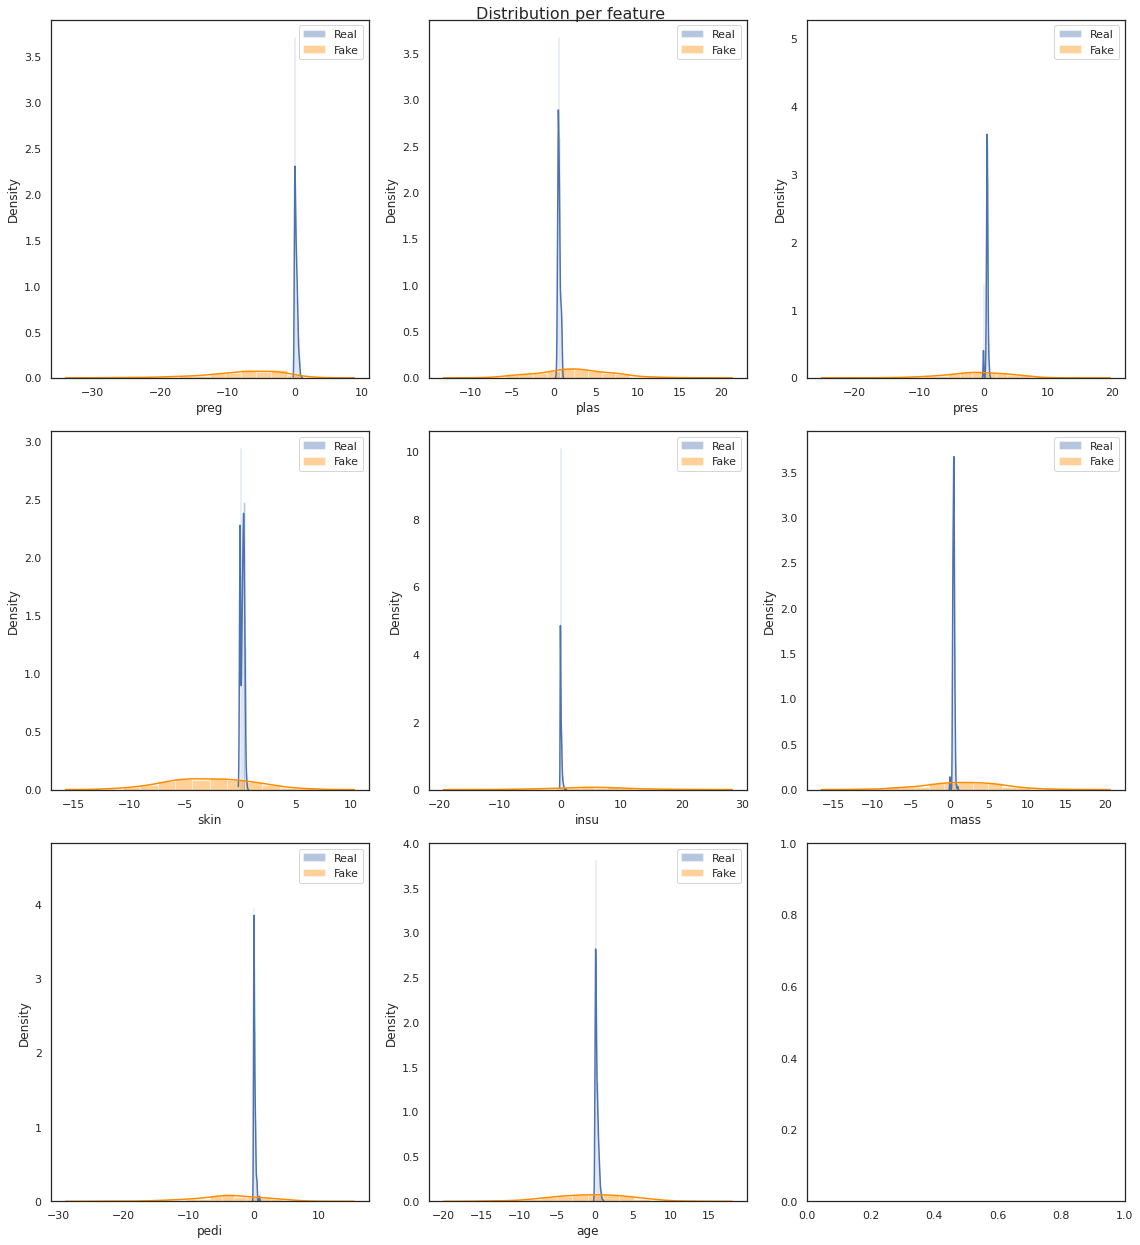

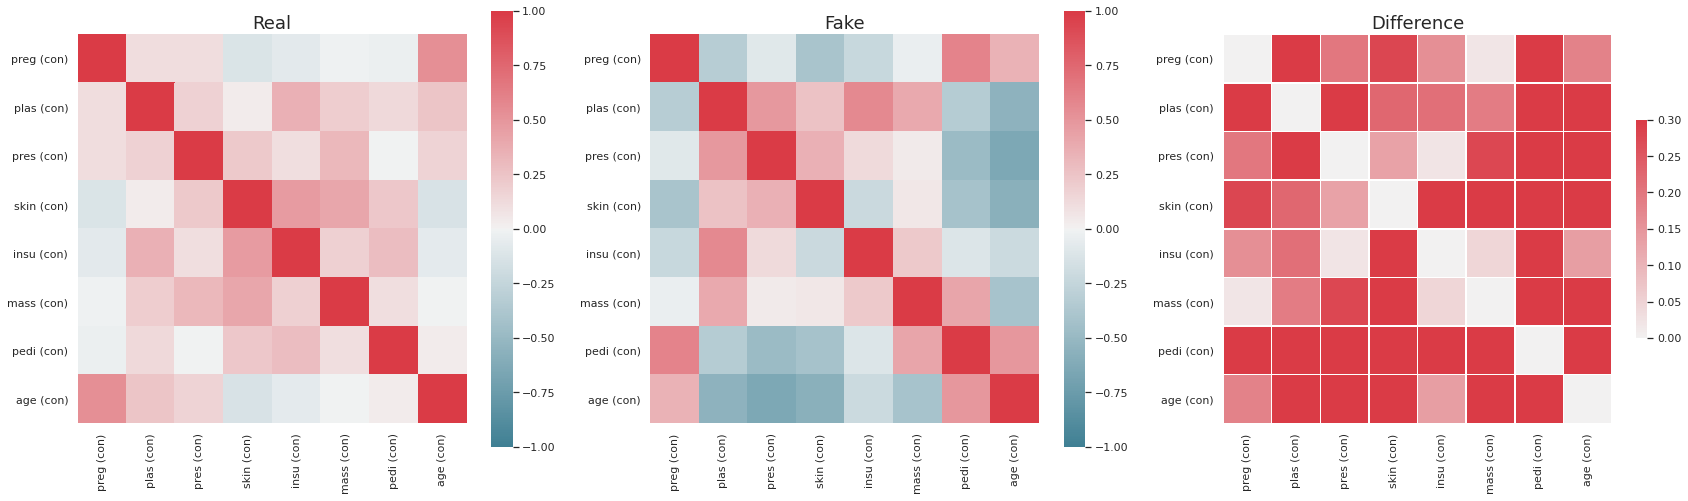

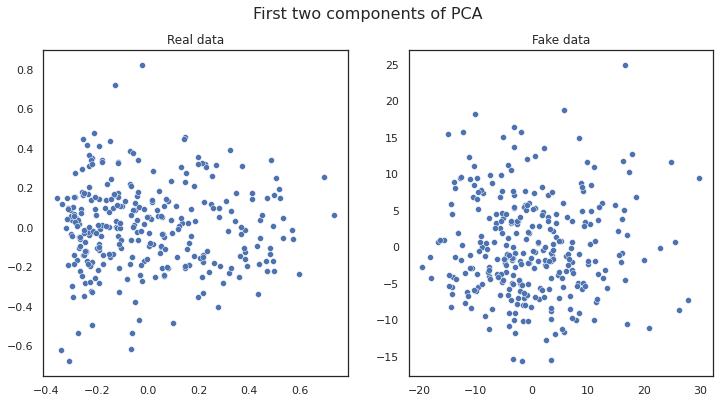

In [ ]:
generated_samples = eval_bbox_GAN(diabetes_BBox_GAN,diabetes_df,diabetes_pipeline)

In [ ]:
generated_samples

,preg,plas,pres,skin,insu,mass,pedi,age
0,-128.277512,-21.456308,167.063034,-181.434875,3797.533203,-310.947815,-14.548838,177.703796
1,-176.875137,-944.607971,-1209.902710,-527.634949,-2859.859375,-162.968948,-3.262046,589.607300
2,-219.179123,1647.416260,386.170380,-40.555874,4420.627441,69.887749,-22.288851,-54.550636
3,-80.679092,-413.064301,-433.850342,-488.628387,5532.688477,-396.068604,-13.523236,225.345734
4,-163.336731,2608.351074,454.087677,-709.120422,12612.695312,359.176453,-15.491166,-160.820206
...,...,...,...,...,...,...,...,...
295,58.301285,1289.698242,644.924866,-842.806580,7456.666016,355.222198,2.520158,5.053962
296,-132.672455,629.339844,189.787491,-45.064552,659.601990,164.628784,-15.338782,-175.860977
297,-19.256426,-96.438705,-463.866638,-101.978210,4812.688477,-185.771683,-9.819371,102.414276
298,-166.060593,52.809494,-455.876923,270.037872,3814.644043,277.593567,-6.629425,-185.416214
